This notebook implements model training, evaluation and hyperparameter tuning for DistilBERT on the *cleaned* dataset, which draws from Pota et al. (2021). All components below follow the same implementation as in the notebook: *DistilBERT (Original Dataset)*, which incorporates model architectural insights from Ingle et al. (2022).

**Addressing Limitations:**

Pota et al. (2021) focused on the benefits of preprocessing for sentiment analysis but did not explore how these strategies interact with model training dynamics. Ingle et al. (2022) proposed a partial fine-tuning approach for RoBERTa to improve training stability, but did not investigate its effects on DistilBERT. This notebook addresses both limitations by combining semantic preprocessing with a partially frozen DistilBERT model. Together, these design choices aim to enhance stability and performance when training on informal tweet data.

**References:**

Ingle, D., Tripathi, R., Kumar, A., Patel, K., & Vepa, J. (2022). Investigating the characteristics of a transformer in a few-shot setup: Does freezing layers in RoBERTa help? *Proceedings of the Fifth BlackboxNLP Workshop on Analyzing and Interpreting Neural Networks for NLP*, 238–248. https://doi.org/10.18653/v1/2022.blackboxnlp-1.19

Pota, M., Ventura, M., Fujita, H., & Esposito, M. (2021). Multilingual evaluation of pre-processing for BERT-based sentiment analysis of tweets. *Expert Systems with Applications, 181*, 115119. https://doi.org/10.1016/j.eswa.2021.115119

---
# **Install & Import Required Libraries**

In [ ]:
# Install required Python libraries for model training and data handling
!pip install torch transformers datasets optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import optuna.visualization as vis
import optuna
import shutil
import os
import json

from google.colab import drive
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments,  AutoModel, AutoConfig, set_seed
from datasets import Dataset
from transformers import EarlyStoppingCallback

set_seed(42)

---
# **1. Data Splitting**

## Load Dataset

In [ ]:
# Load dataset
drive.mount("/content/drive")
data_path = "/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/bert_cleaned_dataset.csv"
df = pd.read_csv(data_path)

# Check dataset information
print(df.info(), "\n")
print(df.head(), "\n")
print(df["label"].value_counts())  # Check class distribution

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   label          100000 non-null  int64 
 1   cleaned_tweet  100000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB
None 

   label                                      cleaned_tweet
0      0  [USER] [URL] - Awww, that's a bummer.  You sho...
1      0  is upset that he can't update his Facebook by ...
2      0  [USER] I dived many times for the ball. Manage...
3      0    my whole body feels itchy and like its on fire 
4      0  [USER] no, it's not behaving at all. i'm mad. ... 

label
0    50000
1    50000
Name: count, dtype: int64


## Train-Test Split (80%-20%)

In [ ]:
# 80%-20% Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(
    df["cleaned_tweet"],  # Use cleaned tweet text
    df["label"],          # Corresponding sentiment labels
    test_size=0.2,        # 20% test set reserved for final evaluation
    random_state=42,      # Ensures reproducibility
    stratify=df["label"]  # Maintains the same proportion of labels in train & test
)

---
# **2. Feature Engineering**

## Load Tokenizer

In [ ]:
# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

## Helper Functions:

### Tokenize the dataset

In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],        # The column that will be tokenized
        truncation=True,         # Cuts off sequences longer than max_length
        padding="max_length",    # Pads shorter sequences to max_length
        max_length=128           # Max token length
    )

### Convert data to Hugging Face dataset format & apply tokenization

In [ ]:
def prepare_dataset(texts, labels):
    '''
    Converts raw texts and labels into a pandas.DataFrame.
    Converts the DataFrame into a Hugging Face Dataset.
    Applies the tokenize_function (defined earlier) to tokenize all entries.
        - When passing data to a Trainer, Hugging Face expects only the necessary inputs:
        - 'input_ids', 'attention_mask', and optionally 'label'
        - Remove "text" & "__index_level_0__" columns that the model won't use
        - The Trainer (and the model) by default expects a column named "labels".
    '''
    df = pd.DataFrame({"text": texts, "label": labels})
    dataset = Dataset.from_pandas(df)
    dataset = dataset.map(tokenize_function, batched=True).remove_columns(set(dataset.column_names) - {"input_ids", "attention_mask", "label"})
    dataset = dataset.rename_column("label", "labels")
    return dataset

---
# **3.1 Initial Model Training**

## Define Training Arguments

In [ ]:
# Training Arguments for GPU
def create_training_args(model_loader):
    return TrainingArguments(
        output_dir=f"./results_{model_loader.__name__}", # Directory to store checkpoints
        report_to="none",                                # Disable WandB logging
        eval_strategy="epoch",                           # Evaluate after each epoch
        save_strategy="epoch",                           # Save checkpoints each epoch
        per_device_train_batch_size=8,                   # Referenced from Pota et al. (2021)
        per_device_eval_batch_size=8,                    # Same as train batch size for consistency
        num_train_epochs=5,                              # Referenced from Pota et al. (2021)
        learning_rate=3e-5,                              # Referenced from Pota et al. (2021)
        weight_decay=0.01,                               # Prevents overfitting by penalizing large weights
        fp16=True,                                       # Enable mixed precision for faster training on GPU
        gradient_accumulation_steps=16,                  # Accumulate gradients to simulate larger batch size (Pota et al., 2021)
        logging_dir=f"./logs_{model_loader.__name__}",   # Directory for logging training metrics
        logging_strategy="epoch",                        # Log training loss once per epoch
        load_best_model_at_end=True,                     # Important for early stopping
        metric_for_best_model="eval_f1",                 # Use F1-score to determine the best model
        greater_is_better=True,                          # Higher F1 is better (for early stopping and best model logic)
        seed=42                                          # Ensures reproducibility
    )

## Custom Model Architecture

In [ ]:
class CustomDistilBERTClassifier(nn.Module):
    def __init__(self, model_name="distilbert-base-cased", num_labels=2,
                 hidden_units=[256, 64], dropout_rate=0.3, activation=nn.ReLU):
        super().__init__()

        # Load DistilBERT (without classification head)
        self.bert = AutoModel.from_pretrained(model_name)

        # Freeze all layers first
        for param in self.bert.parameters():
            param.requires_grad = False

        # Unfreeze last 2 transformer layers (DistilBERT has 6 layers)
        for layer in self.bert.transformer.layer[-2:]:
            for param in layer.parameters():
                param.requires_grad = True

        # Build custom classification head dynamically
        layers = []
        input_size = self.bert.config.hidden_size  # Typically 768

        for hidden_size in hidden_units:
            layers.append(nn.Dropout(dropout_rate))
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(activation())
            input_size = hidden_size

        layers.append(nn.Linear(input_size, num_labels))
        self.classifier = nn.Sequential(*layers)

    def forward(self, input_ids, attention_mask, labels=None):
        # Get [CLS] token embedding
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]

        logits = self.classifier(cls_output)

        # Hugging Face Trainer expects a dict with loss + logits
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}

        return {"logits": logits}

## Helper Functions for Fold-running:

### Load model

In [ ]:
def load_pretrained_model():
    return AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=2)

In [ ]:
def load_custom_model(hidden_units=None, dropout_rate=None, activation=None):
    return CustomDistilBERTClassifier(
        "distilbert-base-cased",
        num_labels=2,
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        activation=activation
    )

### Extract loss histories from the training logs


In [ ]:
def extract_loss_history(log_history):
    # Extract training and evaluation loss histories from log_history
    train_loss_history = [log["loss"] for log in log_history if "loss" in log]
    val_loss_history = [log["eval_loss"] for log in log_history if "eval_loss" in log]
    return train_loss_history, val_loss_history

### Extract evaluation logs from log history and compute the average for each evaluation metric across epochs

In [ ]:
def get_average_epoch_metrics(log_history):
    # Filter logs that include evaluation metrics
    eval_entries = [entry for entry in log_history if "eval_loss" in entry]
    if not eval_entries:
        return {}

    # Get all keys that start with 'eval_'
    metric_keys = [key for key in eval_entries[0].keys() if key.startswith("eval_")]

    avg_metrics = {}
    for key in metric_keys:
        # Compute the average of this metric across all evaluation entries (typically 3 epochs)
        avg_metrics[key] = np.mean([entry[key] for entry in eval_entries])

    return avg_metrics

### Print summary of a fold's results

In [ ]:
def print_fold_summary(fold, avg_epoch_metrics,
                       train_loss_history, val_loss_history,
                       avg_train_loss, avg_eval_loss):

    # Print a formatted summary for a training fold

    print(f"\nFold {fold + 1} Summary")
    print("-" * 50)
    print("\nAverage Metrics Across Epochs:")
    for k, v in avg_epoch_metrics.items():
        print(f"{k:<25}: {v:.4f}")

    print("\nLoss History:")
    print(f"- Training Loss per Epoch   : {[f'{l:.4f}' for l in train_loss_history]}")
    print(f"- Validation Loss per Epoch : {[f'{l:.4f}' for l in val_loss_history]}")
    print(f"- Average Training Loss     : {avg_train_loss:.4f}")
    print(f"- Average Validation Loss   : {avg_eval_loss:.4f}")
    print("=" * 60)

### Define evaluation metrics: accuracy, precision, recall & F1 score

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

## Main Function to Run a Single Fold

In [ ]:
def run_fold(fold, train_texts, train_labels, val_texts, val_labels, training_args, model_loader):
    # Prepare tokenized datasets for training and validation
    train_dataset = prepare_dataset(train_texts, train_labels)
    val_dataset = prepare_dataset(val_texts, val_labels)

    # Load the model and move it to GPU
    model = model_loader()
    model.to(device)

    # Initialize the Trainer with compute_metrics and an early stopping callback
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train() # Train the model on the current fold
    log_history = trainer.state.log_history # Retrieve training log history
    train_loss_history, val_loss_history = extract_loss_history(log_history) # Extract loss histories
    avg_epoch_metrics = get_average_epoch_metrics(log_history) # Compute average evaluation metrics

    # Compute average losses across epochs
    avg_train_loss = np.mean(train_loss_history) if train_loss_history else None
    avg_eval_loss = np.mean(val_loss_history) if val_loss_history else None

    # Print a summary of results for this fold
    print_fold_summary(fold, avg_epoch_metrics, train_loss_history, val_loss_history, avg_train_loss, avg_eval_loss)

    return {
        "avg_epoch_metrics": avg_epoch_metrics, # average evaluation metrics across all epochs
        "train_loss_history": train_loss_history, # training loss history
        "val_loss_history": val_loss_history, # validation loss history
        "avg_train_loss": avg_train_loss, # average training loss across all epochs
        "avg_eval_loss": avg_eval_loss, # average validation loss across all epochs
        "log_history": trainer.state.log_history
    }

## Check GPU Availability

In [ ]:
# Set up GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")  # Should print "cuda" if GPU is available

Using device: cuda


## Perform 5-Fold Cross-Validation on the Training Set

In [ ]:
def run_cross_validation(x_train, y_train, training_args, model_loader, k = 5):
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train, y_train)):
        print(f"\nRunning Fold {fold + 1}/{k}")

        # Split training data into 80% train, 20% validation for this fold
        fold_x_train, fold_x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
        fold_y_train, fold_y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train and evaluate the fold
        result = run_fold(fold, fold_x_train, fold_y_train, fold_x_val, fold_y_val, training_args, model_loader)
        fold_results.append(result)

    return fold_results

**WARNING**: Running the below code chunk will take approximately 1 hour on GPU

In [ ]:
model_loader = load_pretrained_model
training_args = create_training_args(model_loader)
fold_results_pretrained_model = run_cross_validation(x_train, y_train, training_args, model_loader)


Running Fold 1/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.429100,0.381797,0.830500,0.830560,0.830500,0.830492
2,0.325300,0.389958,0.833125,0.833626,0.833125,0.833062
3,0.247400,0.431647,0.831250,0.831251,0.831250,0.831250
4,0.182300,0.480858,0.829562,0.829852,0.829562,0.829525



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4211
eval_accuracy            : 0.8311
eval_precision           : 0.8313
eval_recall              : 0.8311
eval_f1                  : 0.8311
eval_runtime             : 17.7575
eval_samples_per_second  : 901.1322
eval_steps_per_second    : 112.6415

Loss History:
- Training Loss per Epoch   : ['0.4291', '0.3253', '0.2474', '0.1823']
- Validation Loss per Epoch : ['0.3818', '0.3900', '0.4316', '0.4809']
- Average Training Loss     : 0.2960
- Average Validation Loss   : 0.4211

Running Fold 2/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.429900,0.386155,0.826625,0.830945,0.826625,0.826057
2,0.326200,0.381451,0.835750,0.836943,0.835750,0.835604
3,0.248500,0.418197,0.831875,0.832282,0.831875,0.831823
4,0.180900,0.480145,0.831250,0.831264,0.831250,0.831248



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4165
eval_accuracy            : 0.8314
eval_precision           : 0.8329
eval_recall              : 0.8314
eval_f1                  : 0.8312
eval_runtime             : 17.6499
eval_samples_per_second  : 906.5453
eval_steps_per_second    : 113.3183

Loss History:
- Training Loss per Epoch   : ['0.4299', '0.3262', '0.2485', '0.1809']
- Validation Loss per Epoch : ['0.3862', '0.3815', '0.4182', '0.4801']
- Average Training Loss     : 0.2964
- Average Validation Loss   : 0.4165

Running Fold 3/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.432400,0.382622,0.830500,0.833124,0.830500,0.830166
2,0.328400,0.380733,0.836875,0.837477,0.836875,0.836802
3,0.247900,0.412752,0.835562,0.836333,0.835562,0.835468
4,0.183200,0.472910,0.832125,0.832177,0.832125,0.832118



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4123
eval_accuracy            : 0.8338
eval_precision           : 0.8348
eval_recall              : 0.8338
eval_f1                  : 0.8336
eval_runtime             : 17.7621
eval_samples_per_second  : 900.8217
eval_steps_per_second    : 112.6030

Loss History:
- Training Loss per Epoch   : ['0.4324', '0.3284', '0.2479', '0.1832']
- Validation Loss per Epoch : ['0.3826', '0.3807', '0.4128', '0.4729']
- Average Training Loss     : 0.2980
- Average Validation Loss   : 0.4123

Running Fold 4/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.427500,0.388302,0.826063,0.827697,0.826063,0.825845
2,0.325800,0.376591,0.837000,0.837047,0.837000,0.836994
3,0.247000,0.421980,0.833812,0.834555,0.833812,0.833720
4,0.181600,0.477121,0.827625,0.829429,0.827625,0.827389



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4160
eval_accuracy            : 0.8311
eval_precision           : 0.8322
eval_recall              : 0.8311
eval_f1                  : 0.8310
eval_runtime             : 17.8482
eval_samples_per_second  : 896.5258
eval_steps_per_second    : 112.0655

Loss History:
- Training Loss per Epoch   : ['0.4275', '0.3258', '0.2470', '0.1816']
- Validation Loss per Epoch : ['0.3883', '0.3766', '0.4220', '0.4771']
- Average Training Loss     : 0.2955
- Average Validation Loss   : 0.4160

Running Fold 5/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.429600,0.389395,0.827750,0.827935,0.827750,0.827726
2,0.325400,0.382182,0.834063,0.834070,0.834063,0.834062
3,0.246200,0.421678,0.830562,0.830633,0.830562,0.830553
4,0.182700,0.486517,0.827937,0.828023,0.827937,0.827926



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4199
eval_accuracy            : 0.8301
eval_precision           : 0.8302
eval_recall              : 0.8301
eval_f1                  : 0.8301
eval_runtime             : 17.9068
eval_samples_per_second  : 893.5370
eval_steps_per_second    : 111.6923

Loss History:
- Training Loss per Epoch   : ['0.4296', '0.3254', '0.2462', '0.1827']
- Validation Loss per Epoch : ['0.3894', '0.3822', '0.4217', '0.4865']
- Average Training Loss     : 0.2960
- Average Validation Loss   : 0.4199


**WARNING**: Running the below code chunk will take approximately 5 hours on GPU

In [ ]:
# Define architecture experiments
experiments = [
    {"name": "baseline", "hidden_units": [256]},
    {"name": "medium", "hidden_units": [256, 64]},
    {"name": "deep", "hidden_units": [512, 256, 64]},
    {"name": "wide", "hidden_units": [512]},
    {"name": "shallow", "hidden_units": [64]},
]

# Dictionary to store results
fold_results_custom_model = {}

# Loop over each architecture
for exp in experiments:
    print(f"\nRunning Experiment: {exp['name']} | Architecture: {exp['hidden_units']}")

    # Wrap load_custom_model to pass parameters
    model_loader = lambda: load_custom_model(
        hidden_units=exp["hidden_units"],
        dropout_rate=0.3,             # You can also vary this if needed
        activation=nn.ReLU            # Try nn.GELU or nn.Tanh for other runs
    )

    # Create training arguments
    training_args = create_training_args(model_loader)

    # Run 5-fold cross-validation
    fold_results = run_cross_validation(x_train, y_train, training_args, model_loader)

    # Save results under experiment name
    fold_results_custom_model[exp["name"]] = fold_results


Running Experiment: baseline | Architecture: [256]

Running Fold 1/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.482300,0.424514,0.805438,0.805501,0.805438,0.805427
2,0.420700,0.408080,0.817312,0.817458,0.817312,0.817292
3,0.394000,0.404285,0.820500,0.820501,0.820500,0.820500
4,0.375400,0.402070,0.818312,0.818574,0.818312,0.818275
5,0.362300,0.405227,0.819375,0.819393,0.819375,0.819372



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4088
eval_accuracy            : 0.8162
eval_precision           : 0.8163
eval_recall              : 0.8162
eval_f1                  : 0.8162
eval_runtime             : 18.0391
eval_samples_per_second  : 887.1930
eval_steps_per_second    : 110.8988

Loss History:
- Training Loss per Epoch   : ['0.4823', '0.4207', '0.3940', '0.3754', '0.3623']
- Validation Loss per Epoch : ['0.4245', '0.4081', '0.4043', '0.4021', '0.4052']
- Average Training Loss     : 0.4069
- Average Validation Loss   : 0.4088

Running Fold 2/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.482600,0.430861,0.798500,0.800304,0.798500,0.798197
2,0.421000,0.410697,0.810625,0.810886,0.810625,0.810585
3,0.394900,0.404285,0.814063,0.814063,0.814063,0.814062
4,0.375200,0.405980,0.817750,0.817776,0.817750,0.817746
5,0.362400,0.407268,0.818250,0.818252,0.818250,0.818250



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4118
eval_accuracy            : 0.8118
eval_precision           : 0.8123
eval_recall              : 0.8118
eval_f1                  : 0.8118
eval_runtime             : 17.7231
eval_samples_per_second  : 902.8654
eval_steps_per_second    : 112.8580

Loss History:
- Training Loss per Epoch   : ['0.4826', '0.4210', '0.3949', '0.3752', '0.3624']
- Validation Loss per Epoch : ['0.4309', '0.4107', '0.4043', '0.4060', '0.4073']
- Average Training Loss     : 0.4072
- Average Validation Loss   : 0.4118

Running Fold 3/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.485800,0.423586,0.804125,0.804125,0.804125,0.804125
2,0.424500,0.409303,0.813250,0.814192,0.813250,0.813110
3,0.397700,0.401145,0.820625,0.821165,0.820625,0.820550
4,0.379300,0.396313,0.821812,0.821927,0.821812,0.821797
5,0.366100,0.397866,0.823250,0.823268,0.823250,0.823248



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4056
eval_accuracy            : 0.8166
eval_precision           : 0.8169
eval_recall              : 0.8166
eval_f1                  : 0.8166
eval_runtime             : 17.8364
eval_samples_per_second  : 897.0748
eval_steps_per_second    : 112.1344

Loss History:
- Training Loss per Epoch   : ['0.4858', '0.4245', '0.3977', '0.3793', '0.3661']
- Validation Loss per Epoch : ['0.4236', '0.4093', '0.4011', '0.3963', '0.3979']
- Average Training Loss     : 0.4107
- Average Validation Loss   : 0.4056

Running Fold 4/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.482500,0.433770,0.797188,0.799344,0.797188,0.796822
2,0.418700,0.414665,0.809875,0.809970,0.809875,0.809860
3,0.391700,0.415031,0.813187,0.813764,0.813187,0.813102
4,0.374900,0.409032,0.814250,0.814874,0.814250,0.814158
5,0.361200,0.410727,0.817250,0.817302,0.817250,0.817243



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4166
eval_accuracy            : 0.8104
eval_precision           : 0.8111
eval_recall              : 0.8104
eval_f1                  : 0.8102
eval_runtime             : 17.7572
eval_samples_per_second  : 901.1164
eval_steps_per_second    : 112.6394

Loss History:
- Training Loss per Epoch   : ['0.4825', '0.4187', '0.3917', '0.3749', '0.3612']
- Validation Loss per Epoch : ['0.4338', '0.4147', '0.4150', '0.4090', '0.4107']
- Average Training Loss     : 0.4058
- Average Validation Loss   : 0.4166

Running Fold 5/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.479700,0.439663,0.797312,0.797723,0.797312,0.797243
2,0.417200,0.417491,0.810000,0.810000,0.810000,0.810000
3,0.392100,0.412341,0.814625,0.814643,0.814625,0.814622
4,0.373400,0.412278,0.817250,0.817250,0.817250,0.817250
5,0.360500,0.414803,0.817375,0.817405,0.817375,0.817371



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4193
eval_accuracy            : 0.8113
eval_precision           : 0.8114
eval_recall              : 0.8113
eval_f1                  : 0.8113
eval_runtime             : 17.7050
eval_samples_per_second  : 903.7226
eval_steps_per_second    : 112.9654

Loss History:
- Training Loss per Epoch   : ['0.4797', '0.4172', '0.3921', '0.3734', '0.3605']
- Validation Loss per Epoch : ['0.4397', '0.4175', '0.4123', '0.4123', '0.4148']
- Average Training Loss     : 0.4046
- Average Validation Loss   : 0.4193

Running Experiment: medium | Architecture: [256, 64]

Running Fold 1/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.495500,0.432265,0.802250,0.802297,0.802250,0.802242
2,0.425400,0.415340,0.813438,0.814613,0.813438,0.813263
3,0.399100,0.408704,0.818187,0.818413,0.818187,0.818155
4,0.381300,0.406107,0.815813,0.815928,0.815813,0.815796
5,0.369100,0.409898,0.817187,0.817211,0.817187,0.817184



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4145
eval_accuracy            : 0.8134
eval_precision           : 0.8137
eval_recall              : 0.8134
eval_f1                  : 0.8133
eval_runtime             : 17.9553
eval_samples_per_second  : 891.1984
eval_steps_per_second    : 111.3996

Loss History:
- Training Loss per Epoch   : ['0.4955', '0.4254', '0.3991', '0.3813', '0.3691']
- Validation Loss per Epoch : ['0.4323', '0.4153', '0.4087', '0.4061', '0.4099']
- Average Training Loss     : 0.4141
- Average Validation Loss   : 0.4145

Running Fold 2/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.493300,0.434622,0.794562,0.799459,0.794562,0.793719
2,0.425500,0.411943,0.811250,0.811665,0.811250,0.811187
3,0.398800,0.405989,0.815187,0.815275,0.815187,0.815175
4,0.380000,0.405306,0.819375,0.819404,0.819375,0.819371
5,0.365900,0.408192,0.820375,0.820397,0.820375,0.820372



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4132
eval_accuracy            : 0.8121
eval_precision           : 0.8132
eval_recall              : 0.8121
eval_f1                  : 0.8120
eval_runtime             : 17.9098
eval_samples_per_second  : 893.3740
eval_steps_per_second    : 111.6718

Loss History:
- Training Loss per Epoch   : ['0.4933', '0.4255', '0.3988', '0.3800', '0.3659']
- Validation Loss per Epoch : ['0.4346', '0.4119', '0.4060', '0.4053', '0.4082']
- Average Training Loss     : 0.4127
- Average Validation Loss   : 0.4132

Running Fold 3/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.497700,0.429065,0.804937,0.805875,0.804937,0.804788
2,0.427100,0.410659,0.815250,0.815333,0.815250,0.815238
3,0.399400,0.402835,0.821125,0.821173,0.821125,0.821118
4,0.382000,0.401093,0.820875,0.821252,0.820875,0.820822
5,0.368800,0.402316,0.822688,0.822741,0.822688,0.822680



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4092
eval_accuracy            : 0.8170
eval_precision           : 0.8173
eval_recall              : 0.8170
eval_f1                  : 0.8169
eval_runtime             : 17.8791
eval_samples_per_second  : 894.9508
eval_steps_per_second    : 111.8688

Loss History:
- Training Loss per Epoch   : ['0.4977', '0.4271', '0.3994', '0.3820', '0.3688']
- Validation Loss per Epoch : ['0.4291', '0.4107', '0.4028', '0.4011', '0.4023']
- Average Training Loss     : 0.4150
- Average Validation Loss   : 0.4092

Running Fold 4/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.493600,0.442891,0.797438,0.801719,0.797438,0.796716
2,0.425000,0.417205,0.810000,0.810039,0.810000,0.809994
3,0.398700,0.415562,0.814375,0.815373,0.814375,0.814228
4,0.379900,0.410727,0.814375,0.815709,0.814375,0.814179
5,0.367800,0.412213,0.817438,0.817589,0.817438,0.817416



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4197
eval_accuracy            : 0.8107
eval_precision           : 0.8121
eval_recall              : 0.8107
eval_f1                  : 0.8105
eval_runtime             : 17.7884
eval_samples_per_second  : 899.5750
eval_steps_per_second    : 112.4468

Loss History:
- Training Loss per Epoch   : ['0.4936', '0.4250', '0.3987', '0.3799', '0.3678']
- Validation Loss per Epoch : ['0.4429', '0.4172', '0.4156', '0.4107', '0.4122']
- Average Training Loss     : 0.4130
- Average Validation Loss   : 0.4197

Running Fold 5/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.492600,0.442801,0.797063,0.797703,0.797063,0.796953
2,0.423600,0.422111,0.810375,0.810418,0.810375,0.810368
3,0.396500,0.419109,0.812937,0.812942,0.812937,0.812937
4,0.378700,0.418127,0.816438,0.816443,0.816438,0.816437
5,0.367600,0.419571,0.815187,0.815294,0.815187,0.815172



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4243
eval_accuracy            : 0.8104
eval_precision           : 0.8106
eval_recall              : 0.8104
eval_f1                  : 0.8104
eval_runtime             : 18.0108
eval_samples_per_second  : 888.3682
eval_steps_per_second    : 111.0460

Loss History:
- Training Loss per Epoch   : ['0.4926', '0.4236', '0.3965', '0.3787', '0.3676']
- Validation Loss per Epoch : ['0.4428', '0.4221', '0.4191', '0.4181', '0.4196']
- Average Training Loss     : 0.4118
- Average Validation Loss   : 0.4243

Running Experiment: deep | Architecture: [512, 256, 64]

Running Fold 1/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.502900,0.431869,0.802375,0.802404,0.802375,0.802370
2,0.427000,0.417153,0.812688,0.813667,0.812688,0.812541
3,0.402300,0.407102,0.821812,0.821822,0.821812,0.821811
4,0.381800,0.404965,0.819438,0.819570,0.819438,0.819419
5,0.370300,0.408369,0.820688,0.820688,0.820688,0.820687



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4139
eval_accuracy            : 0.8154
eval_precision           : 0.8156
eval_recall              : 0.8154
eval_f1                  : 0.8154
eval_runtime             : 18.1733
eval_samples_per_second  : 880.5230
eval_steps_per_second    : 110.0654

Loss History:
- Training Loss per Epoch   : ['0.5029', '0.4270', '0.4023', '0.3818', '0.3703']
- Validation Loss per Epoch : ['0.4319', '0.4172', '0.4071', '0.4050', '0.4084']
- Average Training Loss     : 0.4169
- Average Validation Loss   : 0.4139

Running Fold 2/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.505500,0.432222,0.800188,0.801671,0.800188,0.799942
2,0.428200,0.415376,0.811000,0.811819,0.811000,0.810876
3,0.401000,0.408408,0.816500,0.816524,0.816500,0.816496
4,0.382200,0.408770,0.817750,0.817776,0.817750,0.817746
5,0.369000,0.409511,0.819250,0.819302,0.819250,0.819243



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4149
eval_accuracy            : 0.8129
eval_precision           : 0.8134
eval_recall              : 0.8129
eval_f1                  : 0.8129
eval_runtime             : 18.2882
eval_samples_per_second  : 874.9198
eval_steps_per_second    : 109.3650

Loss History:
- Training Loss per Epoch   : ['0.5055', '0.4282', '0.4010', '0.3822', '0.3690']
- Validation Loss per Epoch : ['0.4322', '0.4154', '0.4084', '0.4088', '0.4095']
- Average Training Loss     : 0.4172
- Average Validation Loss   : 0.4149

Running Fold 3/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.507800,0.427912,0.805937,0.805962,0.805937,0.805934
2,0.429400,0.410982,0.814438,0.814451,0.814438,0.814435
3,0.402200,0.401553,0.819312,0.819324,0.819312,0.819311
4,0.383400,0.402606,0.821187,0.821514,0.821187,0.821142
5,0.370800,0.401912,0.822750,0.822828,0.822750,0.822739



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4090
eval_accuracy            : 0.8167
eval_precision           : 0.8168
eval_recall              : 0.8167
eval_f1                  : 0.8167
eval_runtime             : 18.1063
eval_samples_per_second  : 883.6954
eval_steps_per_second    : 110.4618

Loss History:
- Training Loss per Epoch   : ['0.5078', '0.4294', '0.4022', '0.3834', '0.3708']
- Validation Loss per Epoch : ['0.4279', '0.4110', '0.4016', '0.4026', '0.4019']
- Average Training Loss     : 0.4187
- Average Validation Loss   : 0.4090

Running Fold 4/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.504100,0.439087,0.796750,0.799732,0.796750,0.796243
2,0.425800,0.418403,0.808187,0.808222,0.808187,0.808182
3,0.399600,0.415537,0.814438,0.815160,0.814438,0.814331
4,0.380500,0.412366,0.814875,0.815610,0.814875,0.814767
5,0.368100,0.413611,0.815625,0.815799,0.815625,0.815600



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4198
eval_accuracy            : 0.8100
eval_precision           : 0.8109
eval_recall              : 0.8100
eval_f1                  : 0.8098
eval_runtime             : 18.2920
eval_samples_per_second  : 874.7152
eval_steps_per_second    : 109.3396

Loss History:
- Training Loss per Epoch   : ['0.5041', '0.4258', '0.3996', '0.3805', '0.3681']
- Validation Loss per Epoch : ['0.4391', '0.4184', '0.4155', '0.4124', '0.4136']
- Average Training Loss     : 0.4156
- Average Validation Loss   : 0.4198

Running Fold 5/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.502700,0.447898,0.796687,0.796693,0.796687,0.796687
2,0.424900,0.420801,0.809625,0.809631,0.809625,0.809624
3,0.398900,0.418251,0.812875,0.812875,0.812875,0.812875
4,0.377500,0.419063,0.815312,0.815323,0.815312,0.815311
5,0.367000,0.419668,0.815312,0.815708,0.815312,0.815255



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4251
eval_accuracy            : 0.8100
eval_precision           : 0.8100
eval_recall              : 0.8100
eval_f1                  : 0.8100
eval_runtime             : 18.2508
eval_samples_per_second  : 876.7696
eval_steps_per_second    : 109.5960

Loss History:
- Training Loss per Epoch   : ['0.5027', '0.4249', '0.3989', '0.3775', '0.3670']
- Validation Loss per Epoch : ['0.4479', '0.4208', '0.4183', '0.4191', '0.4197']
- Average Training Loss     : 0.4142
- Average Validation Loss   : 0.4251

Running Experiment: wide | Architecture: [512]

Running Fold 1/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.482000,0.424381,0.802937,0.803190,0.802937,0.802896
2,0.419900,0.408151,0.815063,0.815409,0.815063,0.815012
3,0.393400,0.404861,0.820312,0.820325,0.820312,0.820311
4,0.373900,0.403554,0.821125,0.821175,0.821125,0.821118
5,0.360700,0.406131,0.822250,0.822250,0.822250,0.822250



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4094
eval_accuracy            : 0.8163
eval_precision           : 0.8165
eval_recall              : 0.8163
eval_f1                  : 0.8163
eval_runtime             : 17.9225
eval_samples_per_second  : 893.0002
eval_steps_per_second    : 111.6250

Loss History:
- Training Loss per Epoch   : ['0.4820', '0.4199', '0.3934', '0.3739', '0.3607']
- Validation Loss per Epoch : ['0.4244', '0.4082', '0.4049', '0.4036', '0.4061']
- Average Training Loss     : 0.4060
- Average Validation Loss   : 0.4094

Running Fold 2/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.481700,0.428585,0.801687,0.802838,0.801687,0.801499
2,0.420200,0.409580,0.812000,0.812310,0.812000,0.811953
3,0.394300,0.402876,0.818000,0.818054,0.818000,0.817992
4,0.374800,0.403964,0.818688,0.818909,0.818688,0.818656
5,0.361600,0.405874,0.820125,0.820140,0.820125,0.820123



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4102
eval_accuracy            : 0.8141
eval_precision           : 0.8145
eval_recall              : 0.8141
eval_f1                  : 0.8140
eval_runtime             : 17.6388
eval_samples_per_second  : 907.1186
eval_steps_per_second    : 113.3900

Loss History:
- Training Loss per Epoch   : ['0.4817', '0.4202', '0.3943', '0.3748', '0.3616']
- Validation Loss per Epoch : ['0.4286', '0.4096', '0.4029', '0.4040', '0.4059']
- Average Training Loss     : 0.4065
- Average Validation Loss   : 0.4102

Running Fold 3/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.485000,0.422903,0.803813,0.804237,0.803813,0.803744
2,0.423000,0.410308,0.814500,0.815983,0.814500,0.814282
3,0.395900,0.400582,0.821875,0.822334,0.821875,0.821812
4,0.377900,0.395746,0.822750,0.822867,0.822750,0.822734
5,0.364500,0.397224,0.823750,0.823786,0.823750,0.823745



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4054
eval_accuracy            : 0.8173
eval_precision           : 0.8178
eval_recall              : 0.8173
eval_f1                  : 0.8173
eval_runtime             : 17.6131
eval_samples_per_second  : 908.4700
eval_steps_per_second    : 113.5588

Loss History:
- Training Loss per Epoch   : ['0.4850', '0.4230', '0.3959', '0.3779', '0.3645']
- Validation Loss per Epoch : ['0.4229', '0.4103', '0.4006', '0.3957', '0.3972']
- Average Training Loss     : 0.4093
- Average Validation Loss   : 0.4054

Running Fold 4/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.481200,0.433226,0.798125,0.800726,0.798125,0.797688
2,0.418400,0.413501,0.810750,0.810762,0.810750,0.810748
3,0.391300,0.414042,0.815625,0.816369,0.815625,0.815517
4,0.373800,0.408471,0.816063,0.816751,0.816063,0.815962
5,0.360500,0.410495,0.817000,0.817071,0.817000,0.816990



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4159
eval_accuracy            : 0.8115
eval_precision           : 0.8123
eval_recall              : 0.8115
eval_f1                  : 0.8114
eval_runtime             : 17.7226
eval_samples_per_second  : 902.8402
eval_steps_per_second    : 112.8550

Loss History:
- Training Loss per Epoch   : ['0.4812', '0.4184', '0.3913', '0.3738', '0.3605']
- Validation Loss per Epoch : ['0.4332', '0.4135', '0.4140', '0.4085', '0.4105']
- Average Training Loss     : 0.4050
- Average Validation Loss   : 0.4159

Running Fold 5/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.479400,0.439067,0.799063,0.799391,0.799063,0.799007
2,0.416700,0.418153,0.809187,0.809403,0.809187,0.809154
3,0.392300,0.411837,0.812250,0.812259,0.812250,0.812249
4,0.373300,0.410978,0.815813,0.815822,0.815813,0.815811
5,0.360500,0.413691,0.816375,0.816511,0.816375,0.816355



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4187
eval_accuracy            : 0.8105
eval_precision           : 0.8107
eval_recall              : 0.8105
eval_f1                  : 0.8105
eval_runtime             : 17.7140
eval_samples_per_second  : 903.2612
eval_steps_per_second    : 112.9074

Loss History:
- Training Loss per Epoch   : ['0.4794', '0.4167', '0.3923', '0.3733', '0.3605']
- Validation Loss per Epoch : ['0.4391', '0.4182', '0.4118', '0.4110', '0.4137']
- Average Training Loss     : 0.4044
- Average Validation Loss   : 0.4187

Running Experiment: shallow | Architecture: [64]

Running Fold 1/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.485100,0.424736,0.803188,0.803274,0.803188,0.803173
2,0.421200,0.408993,0.815250,0.815774,0.815250,0.815173
3,0.394700,0.405195,0.820625,0.820638,0.820625,0.820623
4,0.376000,0.402601,0.820375,0.820404,0.820375,0.820371
5,0.363100,0.404774,0.820688,0.820690,0.820688,0.820687



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4093
eval_accuracy            : 0.8160
eval_precision           : 0.8162
eval_recall              : 0.8160
eval_f1                  : 0.8160
eval_runtime             : 17.6927
eval_samples_per_second  : 904.3328
eval_steps_per_second    : 113.0416

Loss History:
- Training Loss per Epoch   : ['0.4851', '0.4212', '0.3947', '0.3760', '0.3631']
- Validation Loss per Epoch : ['0.4247', '0.4090', '0.4052', '0.4026', '0.4048']
- Average Training Loss     : 0.4080
- Average Validation Loss   : 0.4093

Running Fold 2/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.483600,0.429771,0.798875,0.800873,0.798875,0.798540
2,0.421700,0.411248,0.809813,0.810593,0.809813,0.809693
3,0.394600,0.404467,0.816063,0.816200,0.816063,0.816042
4,0.376400,0.405240,0.817625,0.817921,0.817625,0.817583
5,0.362700,0.406312,0.817875,0.817929,0.817875,0.817867



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4114
eval_accuracy            : 0.8120
eval_precision           : 0.8127
eval_recall              : 0.8120
eval_f1                  : 0.8119
eval_runtime             : 17.7118
eval_samples_per_second  : 903.3650
eval_steps_per_second    : 112.9208

Loss History:
- Training Loss per Epoch   : ['0.4836', '0.4217', '0.3946', '0.3764', '0.3627']
- Validation Loss per Epoch : ['0.4298', '0.4112', '0.4045', '0.4052', '0.4063']
- Average Training Loss     : 0.4078
- Average Validation Loss   : 0.4114

Running Fold 3/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.489200,0.423323,0.804625,0.804957,0.804625,0.804572
2,0.424500,0.407601,0.813125,0.813487,0.813125,0.813071
3,0.397300,0.399988,0.820125,0.820263,0.820125,0.820106
4,0.378600,0.396193,0.820063,0.820316,0.820063,0.820027
5,0.366900,0.397260,0.822875,0.823065,0.822875,0.822849



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4049
eval_accuracy            : 0.8162
eval_precision           : 0.8164
eval_recall              : 0.8162
eval_f1                  : 0.8161
eval_runtime             : 17.6963
eval_samples_per_second  : 904.2106
eval_steps_per_second    : 113.0262

Loss History:
- Training Loss per Epoch   : ['0.4892', '0.4245', '0.3973', '0.3786', '0.3669']
- Validation Loss per Epoch : ['0.4233', '0.4076', '0.4000', '0.3962', '0.3973']
- Average Training Loss     : 0.4113
- Average Validation Loss   : 0.4049

Running Fold 4/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.484300,0.434614,0.796750,0.798987,0.796750,0.796369
2,0.420100,0.414126,0.809813,0.809816,0.809813,0.809812
3,0.393600,0.416474,0.813500,0.814477,0.813500,0.813355
4,0.376400,0.411462,0.815438,0.816823,0.815438,0.815236
5,0.362200,0.410964,0.814250,0.814479,0.814250,0.814216



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4175
eval_accuracy            : 0.8100
eval_precision           : 0.8109
eval_recall              : 0.8100
eval_f1                  : 0.8098
eval_runtime             : 17.7761
eval_samples_per_second  : 900.1278
eval_steps_per_second    : 112.5160

Loss History:
- Training Loss per Epoch   : ['0.4843', '0.4201', '0.3936', '0.3764', '0.3622']
- Validation Loss per Epoch : ['0.4346', '0.4141', '0.4165', '0.4115', '0.4110']
- Average Training Loss     : 0.4073
- Average Validation Loss   : 0.4175

Running Fold 5/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.483400,0.439160,0.796312,0.796633,0.796312,0.796257
2,0.418100,0.417649,0.810500,0.810647,0.810500,0.810478
3,0.393300,0.411957,0.814125,0.814127,0.814125,0.814125
4,0.374400,0.411162,0.816937,0.816975,0.816937,0.816932
5,0.362600,0.414164,0.816500,0.816845,0.816500,0.816450



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4188
eval_accuracy            : 0.8109
eval_precision           : 0.8110
eval_recall              : 0.8109
eval_f1                  : 0.8108
eval_runtime             : 17.7108
eval_samples_per_second  : 903.4686
eval_steps_per_second    : 112.9338

Loss History:
- Training Loss per Epoch   : ['0.4834', '0.4181', '0.3933', '0.3744', '0.3626']
- Validation Loss per Epoch : ['0.4392', '0.4176', '0.4120', '0.4112', '0.4142']
- Average Training Loss     : 0.4064
- Average Validation Loss   : 0.4188


In [ ]:
for name, results in fold_results_custom_model.items():
    accs = [fold["avg_epoch_metrics"].get("eval_accuracy", np.nan) for fold in results]
    precs = [fold["avg_epoch_metrics"].get("eval_precision", np.nan) for fold in results]
    recalls = [fold["avg_epoch_metrics"].get("eval_recall", np.nan) for fold in results]
    f1s = [fold["avg_epoch_metrics"].get("eval_f1", np.nan) for fold in results]

    avg_acc = np.nanmean(accs)
    avg_prec = np.nanmean(precs)
    avg_recall = np.nanmean(recalls)
    avg_f1 = np.nanmean(f1s)

    print("Average Metrics for Each Experiment:")
    print(f"{name:<10} | Acc: {avg_acc:.4f} | Prec: {avg_prec:.4f} | Recall: {avg_recall:.4f} | F1: {avg_f1:.4f}")

Average Metrics for Each Experiment:
baseline   | Acc: 0.8133 | Prec: 0.8136 | Recall: 0.8133 | F1: 0.8132
Average Metrics for Each Experiment:
medium     | Acc: 0.8127 | Prec: 0.8134 | Recall: 0.8127 | F1: 0.8126
Average Metrics for Each Experiment:
deep       | Acc: 0.8130 | Prec: 0.8134 | Recall: 0.8130 | F1: 0.8129
Average Metrics for Each Experiment:
wide       | Acc: 0.8140 | Prec: 0.8144 | Recall: 0.8140 | F1: 0.8139
Average Metrics for Each Experiment:
shallow    | Acc: 0.8130 | Prec: 0.8134 | Recall: 0.8130 | F1: 0.8129


---
# **3.2 Initial Model Evaluation**

## Helper Functions for Visualization:

### Plot average of evaluation metrics for all epochs per fold

In [ ]:
def plot_avg_epoch_metrics_per_fold(metrics_list):
    folds = np.arange(1, len(metrics_list) + 1)
    avg_accuracies = [m["avg_epoch_metrics"]["eval_accuracy"] for m in metrics_list]
    avg_precisions = [m["avg_epoch_metrics"]["eval_precision"] for m in metrics_list]
    avg_recalls = [m["avg_epoch_metrics"]["eval_recall"] for m in metrics_list]
    avg_f1s = [m["avg_epoch_metrics"]["eval_f1"] for m in metrics_list]

    plt.figure(figsize=(14, 4))

    # Accuracy
    plt.subplot(1, 4, 1)
    plt.bar(folds, [acc * 100 for acc in avg_accuracies], color='skyblue')
    plt.xlabel("Fold")
    plt.title("Average Accuracy (%) per Fold")
    plt.ylim(0, 100)

    # Precision
    plt.subplot(1, 4, 2)
    plt.bar(folds, [prec * 100 for prec in avg_precisions], color='lightgreen')
    plt.xlabel("Fold")
    plt.title("Average Precision (%) per Fold")
    plt.ylim(0, 100)

    # Recall
    plt.subplot(1, 4, 3)
    plt.bar(folds, [rec * 100 for rec in avg_recalls], color='salmon')
    plt.xlabel("Fold")
    plt.title("Average Recall (%) per Fold")
    plt.ylim(0, 100)

    # F1 Score
    plt.subplot(1, 4, 4)
    plt.bar(folds, [f1 * 100 for f1 in avg_f1s], color='plum')
    plt.xlabel("Fold")
    plt.title("Average F1 Score (%) per Fold")
    plt.ylim(0, 100)

    plt.tight_layout()
    plt.show()

    # Print a summary table of average epoch metrics per fold
    print("\nAverage Metrics (%) Across Epochs Per Fold:")
    print("-" * 60)
    print(f"{'Fold':<6}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1 Score':<12}")
    print("-" * 60)
    for i in range(len(folds)):
        print(f"{folds[i]:<6}{avg_accuracies[i]*100:<12.2f}{avg_precisions[i]*100:<12.2f}{avg_recalls[i]*100:<12.2f}{avg_f1s[i]*100:<12.2f}")


### Plot overall average of evaluation metrics for all epochs for 5-fold

In [ ]:
def plot_avg_epoch_metrics_across_folds(metrics_list):
    avg_accuracy = np.mean([m["avg_epoch_metrics"]["eval_accuracy"] for m in metrics_list])
    avg_precision = np.mean([m["avg_epoch_metrics"]["eval_precision"] for m in metrics_list])
    avg_recall = np.mean([m["avg_epoch_metrics"]["eval_recall"] for m in metrics_list])
    avg_f1 = np.mean([m["avg_epoch_metrics"]["eval_f1"] for m in metrics_list])

    metrics_names = ["Accuracy", "Precision", "Recall", "F1"]
    avg_values = [avg_accuracy * 100, avg_precision * 100, avg_recall * 100, avg_f1 * 100]

    plt.figure(figsize=(6, 4))
    plt.bar(metrics_names, avg_values, color='mediumseagreen')
    plt.ylabel("Average Metric Value (%)")
    plt.title("Overall Average Metrics (%) across 5 Folds")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

    # Print a summary table of overall avg metrics for all epohcs across folds
    print("\nOverall Average Metrics Across Folds:")
    print("-" * 40)
    print(f"{'Metric':<12}{'Value (%)':>10}")
    print("-" * 40)
    for name, value in zip(metrics_names, avg_values):
        print(f"{name:<12}{value:>10.2f}")

### Plot training and validation loss curves per fold

In [ ]:
def plot_loss_per_fold(metrics_list):
    plt.figure(figsize=(10, 6))

    # To save loss data per fold
    loss_data_all_folds = []

    # Loop over each fold's results
    for i, res in enumerate(metrics_list):
        train_loss = res["train_loss_history"]  # List of training losses (one per epoch)
        val_loss = res["val_loss_history"]      # List of validation losses (one per epoch)

        # Create x-axis values representing epoch numbers
        epochs_train = range(1, len(train_loss) + 1)
        epochs_val = range(1, len(val_loss) + 1)

        # Plot training loss (solid line) and validation loss (dashed line)
        plt.plot(epochs_train, train_loss, marker='o', linestyle='-', label=f"Train Loss - Fold {i+1}")
        plt.plot(epochs_val, val_loss, marker='o', linestyle='--', label=f"Val Loss - Fold {i+1}")

        # Collect loss data for each epoch
        for epoch, t_loss, v_loss in zip(epochs_train, train_loss, val_loss):
            loss_data_all_folds.append({
                "Fold": i + 1,
                "Epoch": epoch,
                "Train Loss": t_loss,
                "Validation Loss": v_loss
            })

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curves per Fold")
    plt.xticks(range(1, max(len(res["train_loss_history"]) for res in metrics_list) + 1)) # Set x-ticks based on the max no of epochs in any fold
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Convert to DataFrame
    df_loss = pd.DataFrame(loss_data_all_folds)

    # Print summary table of loss values
    print("\nLoss Values per Fold and Epoch:")
    print("-" * 50)
    print(f"{'Fold':<6}{'Epoch':<8}{'Train Loss':<15}{'Val Loss':<15}")
    print("-" * 50)
    previous_fold = None
    for _, row in df_loss.iterrows():
        current_fold = int(row['Fold'])
        if previous_fold is not None and current_fold != previous_fold:
            print("-" * 50)  # Separator between folds
        print(f"{current_fold:<6}{int(row['Epoch']):<8}{row['Train Loss']:<15.4f}{row['Validation Loss']:<15.4f}")
        previous_fold = current_fold

    return df_loss

### Plot average of training and validation loss curves for 5-fold

In [ ]:
def plot_avg_loss_across_folds(metrics_list):
    # Extract training and validation loss histories from each fold
    train_loss_histories = [res["train_loss_history"] for res in metrics_list]
    val_loss_histories = [res["val_loss_history"] for res in metrics_list]

    # Find the minimum number of epochs across all folds
    min_epochs = min(min(len(loss) for loss in train_loss_histories),
                     min(len(loss) for loss in val_loss_histories))

    # Trim each fold's loss history to match the minimum number of epochs
    trimmed_train_losses = [loss[:min_epochs] for loss in train_loss_histories]
    trimmed_val_losses = [loss[:min_epochs] for loss in val_loss_histories]

    # Compute average loss at each epoch
    avg_train_loss = np.mean(trimmed_train_losses, axis=0)
    avg_val_loss = np.mean(trimmed_val_losses, axis=0)

    # Plot the average loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, min_epochs+1), avg_train_loss, color='blue', marker='o', linestyle='-', label="Avg Train Loss")
    plt.plot(range(1, min_epochs+1), avg_val_loss, color='red', marker='s', linestyle='--', label="Avg Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Average Training & Validation Loss Curve Across 5 Folds")
    plt.xticks(range(1, min_epochs + 1))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Create DataFrame
    df_loss = pd.DataFrame({
        "Epoch": list(range(1, min_epochs + 1)),
        "Avg Train Loss": avg_train_loss,
        "Avg Validation Loss": avg_val_loss
    })

    # Print summary table of avg loss values
    print("\nAverage Loss per Epoch Across Folds:")
    print("-" * 45)
    print(f"{'Epoch':<8}{'Train Loss':<16}{'Val Loss':<16}")
    print("-" * 45)
    for epoch in range(min_epochs):
        print(f"{epoch+1:<8}{avg_train_loss[epoch]:<16.4f}{avg_val_loss[epoch]:<16.4f}")

    return df_loss

## Visualize & Evaluate Performance Metrics:

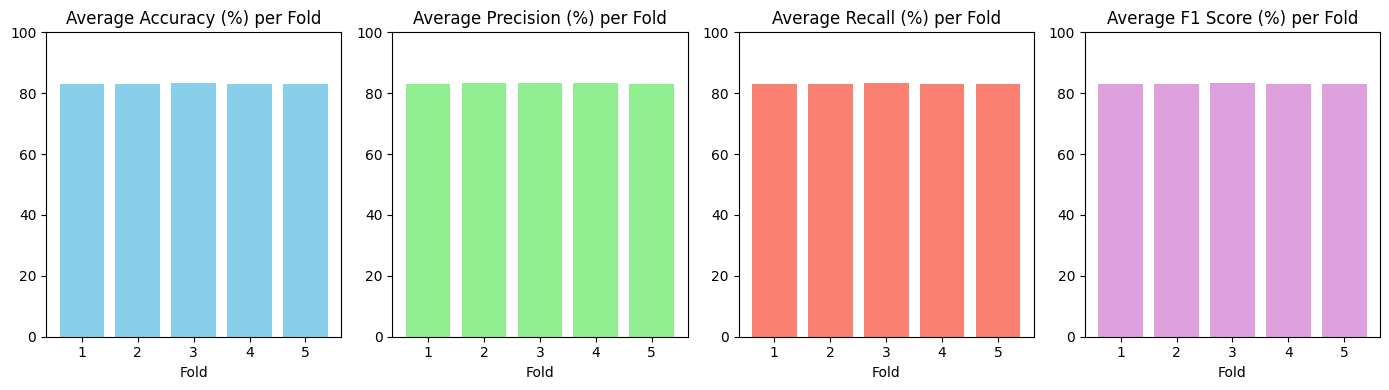


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     83.11       83.13       83.11       83.11       
2     83.14       83.29       83.14       83.12       
3     83.38       83.48       83.38       83.36       
4     83.11       83.22       83.11       83.10       
5     83.01       83.02       83.01       83.01       

Plotting results for experiment: baseline



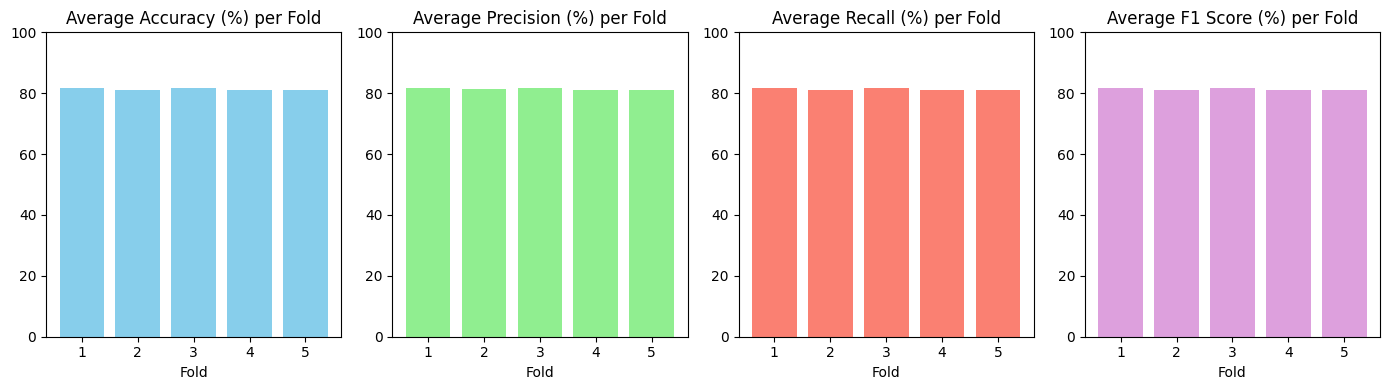


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     81.62       81.63       81.62       81.62       
2     81.18       81.23       81.18       81.18       
3     81.66       81.69       81.66       81.66       
4     81.03       81.11       81.03       81.02       
5     81.13       81.14       81.13       81.13       

Plotting results for experiment: medium



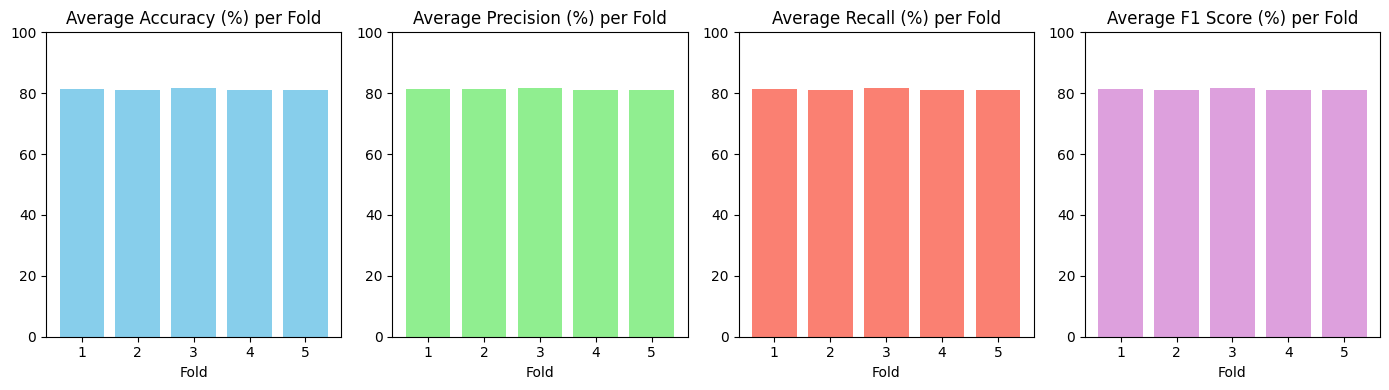


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     81.34       81.37       81.34       81.33       
2     81.21       81.32       81.21       81.20       
3     81.70       81.73       81.70       81.69       
4     81.07       81.21       81.07       81.05       
5     81.04       81.06       81.04       81.04       

Plotting results for experiment: deep



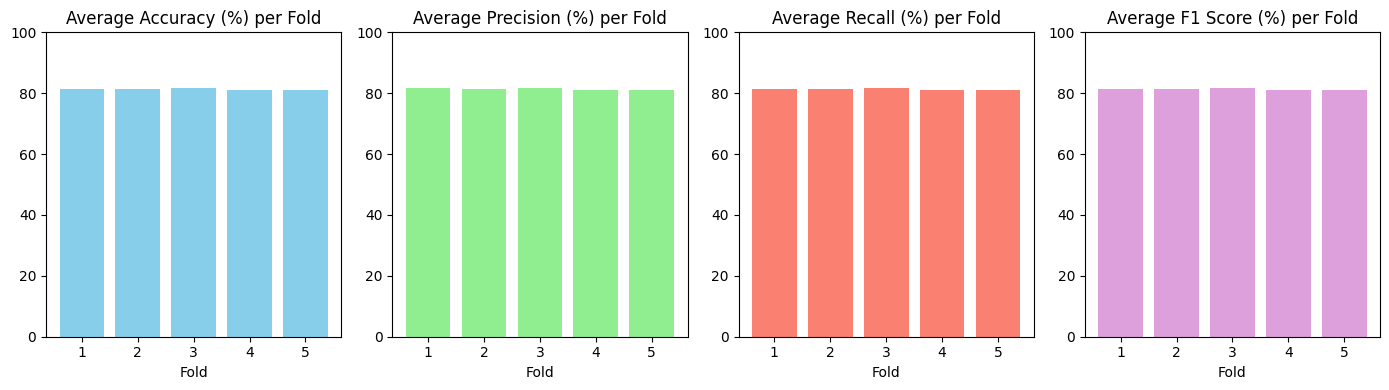


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     81.54       81.56       81.54       81.54       
2     81.29       81.34       81.29       81.29       
3     81.67       81.68       81.67       81.67       
4     81.00       81.09       81.00       80.98       
5     81.00       81.00       81.00       81.00       

Plotting results for experiment: wide



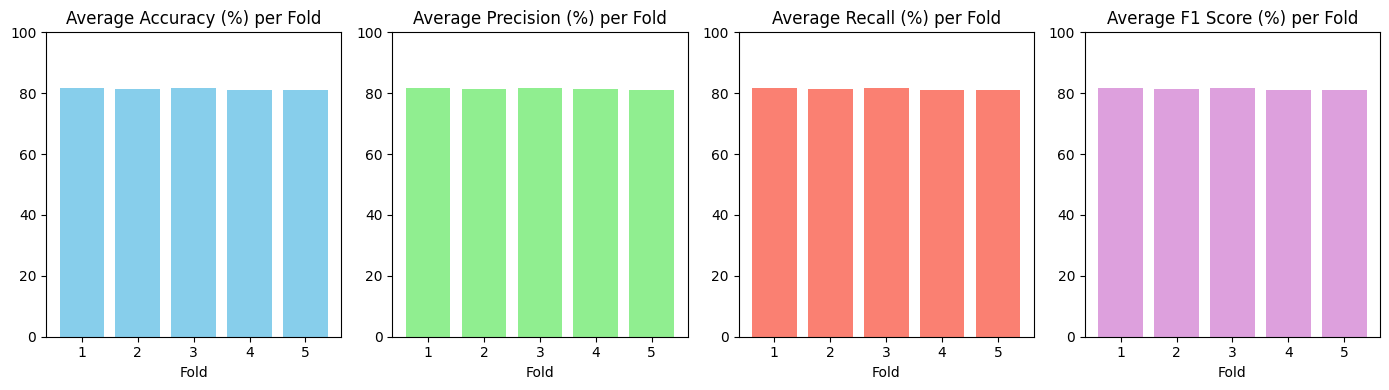


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     81.63       81.65       81.63       81.63       
2     81.41       81.45       81.41       81.40       
3     81.73       81.78       81.73       81.73       
4     81.15       81.23       81.15       81.14       
5     81.05       81.07       81.05       81.05       

Plotting results for experiment: shallow



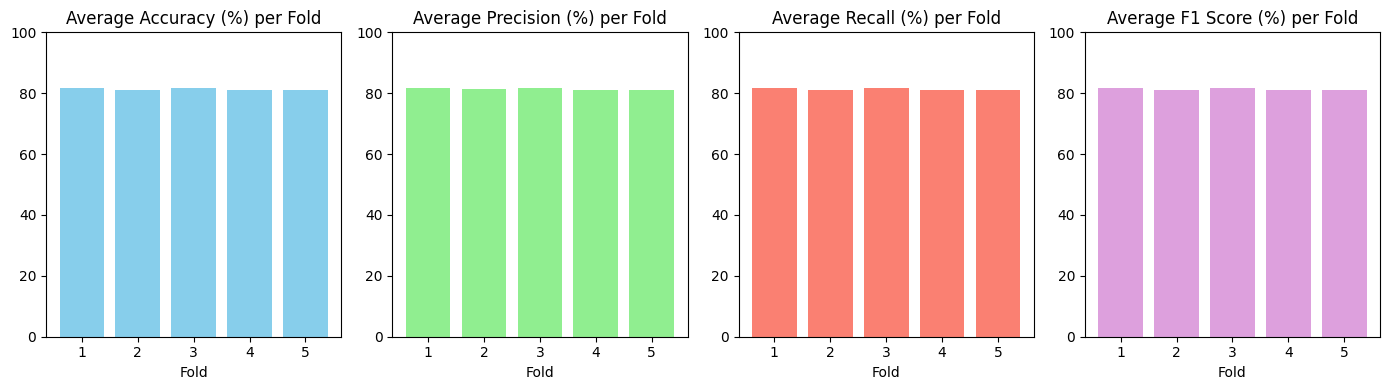


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     81.60       81.62       81.60       81.60       
2     81.20       81.27       81.20       81.19       
3     81.62       81.64       81.62       81.61       
4     81.00       81.09       81.00       80.98       
5     81.09       81.10       81.09       81.08       


In [ ]:
# Plot cross-validation performance metrics (average of epochs) per fold
plot_avg_epoch_metrics_per_fold(fold_results_pretrained_model)

for experiment_name, experiment_results in fold_results_custom_model.items():
    print(f"\nPlotting results for experiment: {experiment_name}\n")
    plot_avg_epoch_metrics_per_fold(experiment_results)

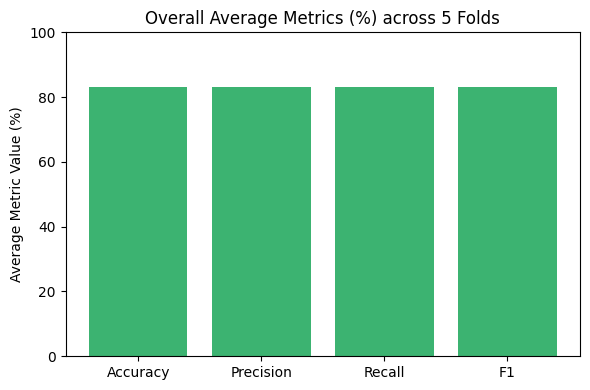


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         83.15
Precision        83.23
Recall           83.15
F1               83.14

Plotting results for experiment: baseline



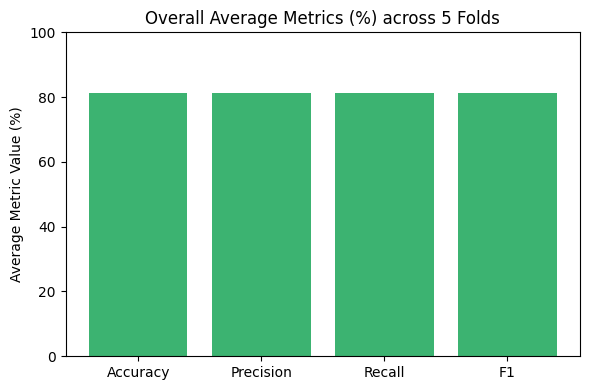


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         81.33
Precision        81.36
Recall           81.33
F1               81.32

Plotting results for experiment: medium



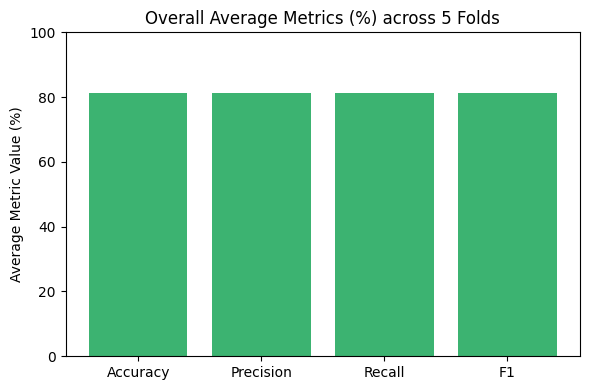


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         81.27
Precision        81.34
Recall           81.27
F1               81.26

Plotting results for experiment: deep



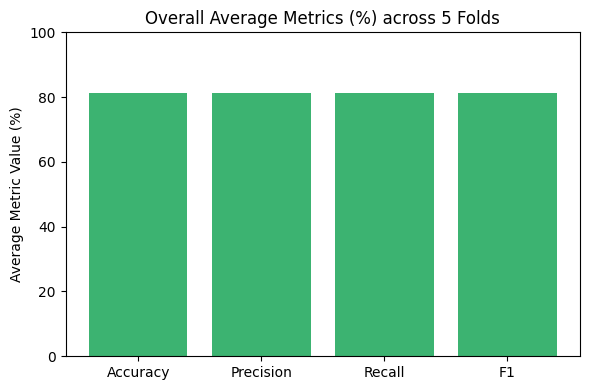


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         81.30
Precision        81.34
Recall           81.30
F1               81.29

Plotting results for experiment: wide



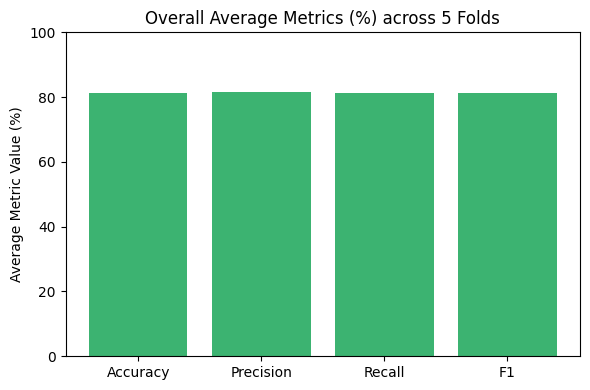


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         81.40
Precision        81.44
Recall           81.40
F1               81.39

Plotting results for experiment: shallow



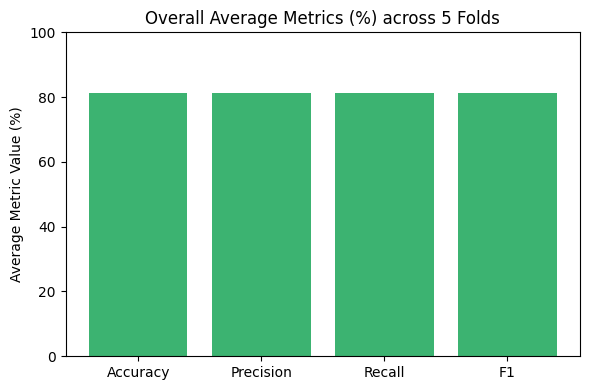


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         81.30
Precision        81.34
Recall           81.30
F1               81.29


In [ ]:
# Plot average performance metrics (average of epochs) for 5-fold
plot_avg_epoch_metrics_across_folds(fold_results_pretrained_model)

for experiment_name, experiment_results in fold_results_custom_model.items():
    print(f"\nPlotting results for experiment: {experiment_name}\n")
    plot_avg_epoch_metrics_across_folds(experiment_results)

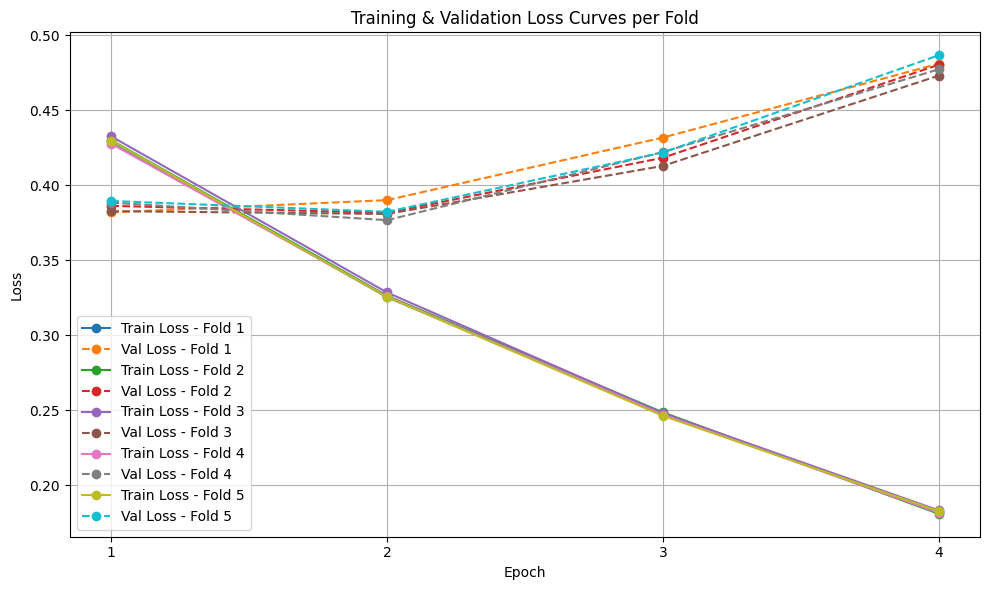


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4291         0.3818         
1     2       0.3253         0.3900         
1     3       0.2474         0.4316         
1     4       0.1823         0.4809         
--------------------------------------------------
2     1       0.4299         0.3862         
2     2       0.3262         0.3815         
2     3       0.2485         0.4182         
2     4       0.1809         0.4801         
--------------------------------------------------
3     1       0.4324         0.3826         
3     2       0.3284         0.3807         
3     3       0.2479         0.4128         
3     4       0.1832         0.4729         
--------------------------------------------------
4     1       0.4275         0.3883         
4     2       0.3258         0.3766         
4     3       0.2470         0.4220  

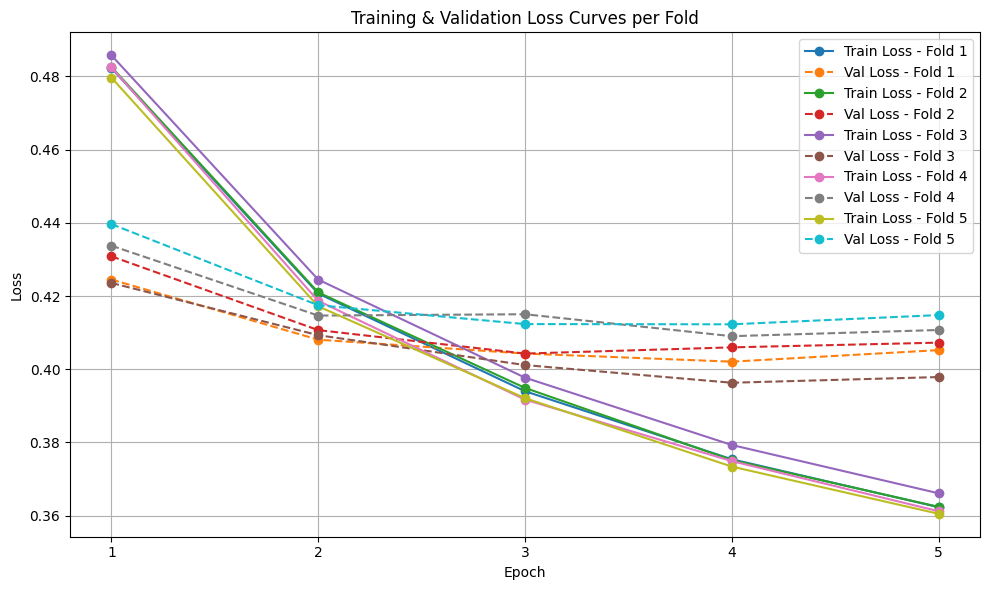


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4823         0.4245         
1     2       0.4207         0.4081         
1     3       0.3940         0.4043         
1     4       0.3754         0.4021         
1     5       0.3623         0.4052         
--------------------------------------------------
2     1       0.4826         0.4309         
2     2       0.4210         0.4107         
2     3       0.3949         0.4043         
2     4       0.3752         0.4060         
2     5       0.3624         0.4073         
--------------------------------------------------
3     1       0.4858         0.4236         
3     2       0.4245         0.4093         
3     3       0.3977         0.4011         
3     4       0.3793         0.3963         
3     5       0.3661         0.3979         
-------------------------------------------

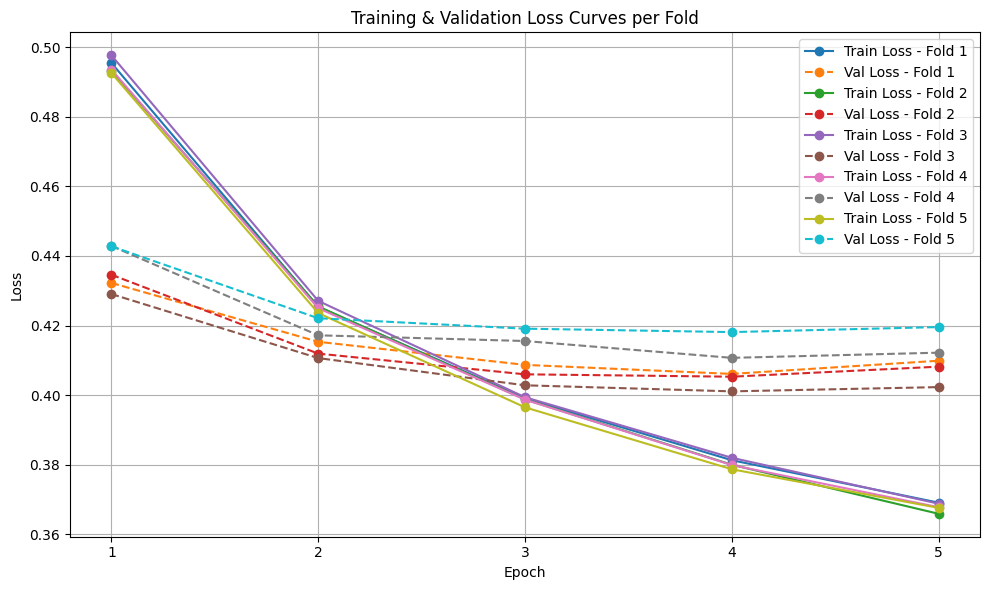


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4955         0.4323         
1     2       0.4254         0.4153         
1     3       0.3991         0.4087         
1     4       0.3813         0.4061         
1     5       0.3691         0.4099         
--------------------------------------------------
2     1       0.4933         0.4346         
2     2       0.4255         0.4119         
2     3       0.3988         0.4060         
2     4       0.3800         0.4053         
2     5       0.3659         0.4082         
--------------------------------------------------
3     1       0.4977         0.4291         
3     2       0.4271         0.4107         
3     3       0.3994         0.4028         
3     4       0.3820         0.4011         
3     5       0.3688         0.4023         
-------------------------------------------

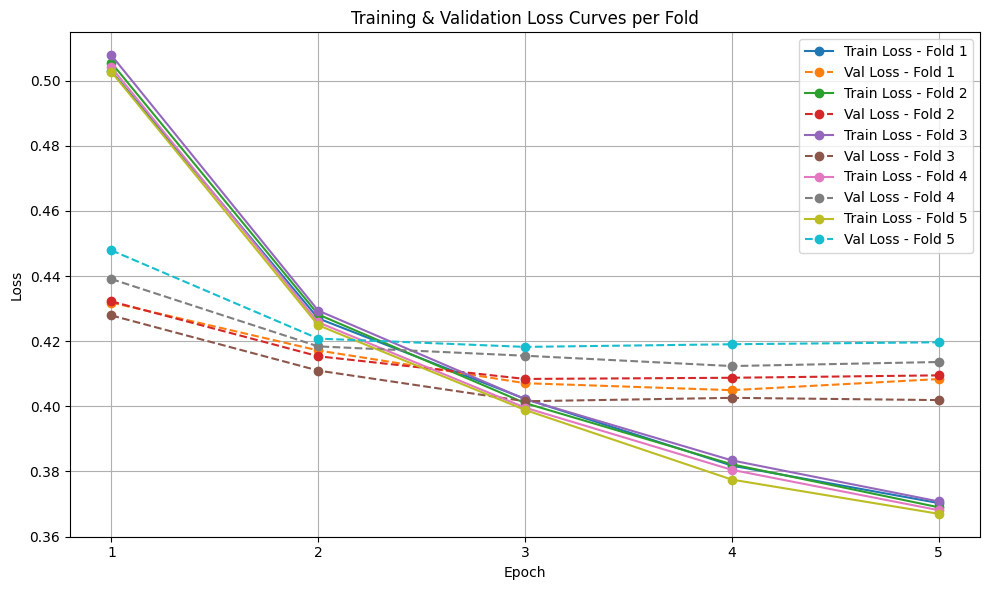


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.5029         0.4319         
1     2       0.4270         0.4172         
1     3       0.4023         0.4071         
1     4       0.3818         0.4050         
1     5       0.3703         0.4084         
--------------------------------------------------
2     1       0.5055         0.4322         
2     2       0.4282         0.4154         
2     3       0.4010         0.4084         
2     4       0.3822         0.4088         
2     5       0.3690         0.4095         
--------------------------------------------------
3     1       0.5078         0.4279         
3     2       0.4294         0.4110         
3     3       0.4022         0.4016         
3     4       0.3834         0.4026         
3     5       0.3708         0.4019         
-------------------------------------------

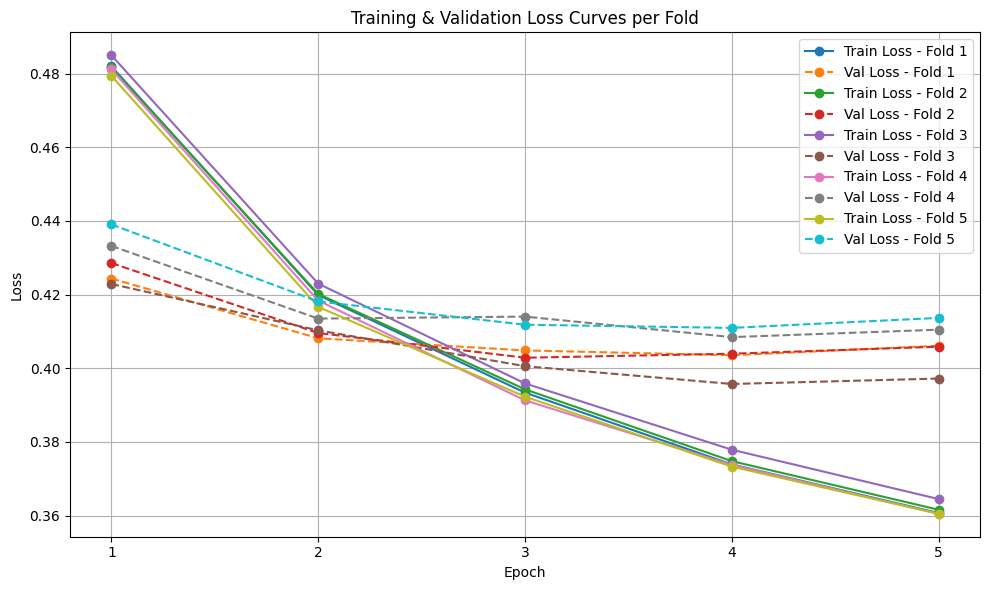


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4820         0.4244         
1     2       0.4199         0.4082         
1     3       0.3934         0.4049         
1     4       0.3739         0.4036         
1     5       0.3607         0.4061         
--------------------------------------------------
2     1       0.4817         0.4286         
2     2       0.4202         0.4096         
2     3       0.3943         0.4029         
2     4       0.3748         0.4040         
2     5       0.3616         0.4059         
--------------------------------------------------
3     1       0.4850         0.4229         
3     2       0.4230         0.4103         
3     3       0.3959         0.4006         
3     4       0.3779         0.3957         
3     5       0.3645         0.3972         
-------------------------------------------

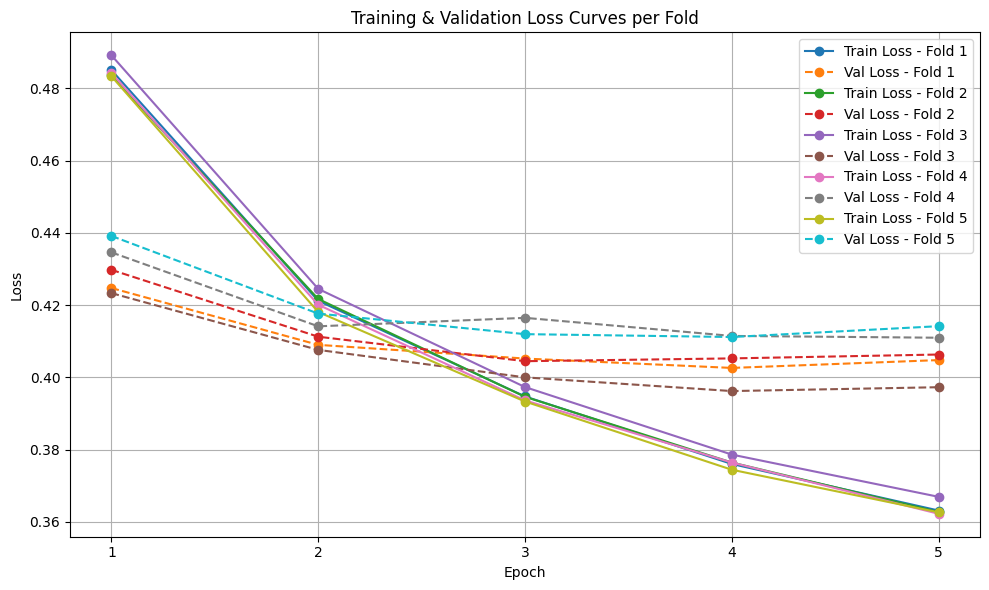


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4851         0.4247         
1     2       0.4212         0.4090         
1     3       0.3947         0.4052         
1     4       0.3760         0.4026         
1     5       0.3631         0.4048         
--------------------------------------------------
2     1       0.4836         0.4298         
2     2       0.4217         0.4112         
2     3       0.3946         0.4045         
2     4       0.3764         0.4052         
2     5       0.3627         0.4063         
--------------------------------------------------
3     1       0.4892         0.4233         
3     2       0.4245         0.4076         
3     3       0.3973         0.4000         
3     4       0.3786         0.3962         
3     5       0.3669         0.3973         
-------------------------------------------

In [ ]:
# Plot training and validation loss curves per fold
plot_loss_per_fold(fold_results_pretrained_model)

for experiment_name, experiment_results in fold_results_custom_model.items():
    print(f"\nPlotting results for experiment: {experiment_name}\n")
    plot_loss_per_fold(experiment_results)

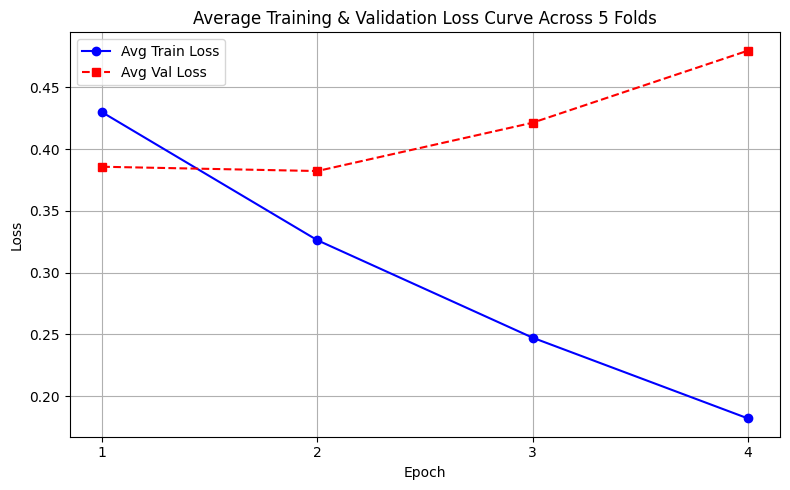


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4297          0.3857          
2       0.3262          0.3822          
3       0.2474          0.4213          
4       0.1821          0.4795          

Plotting results for experiment: baseline



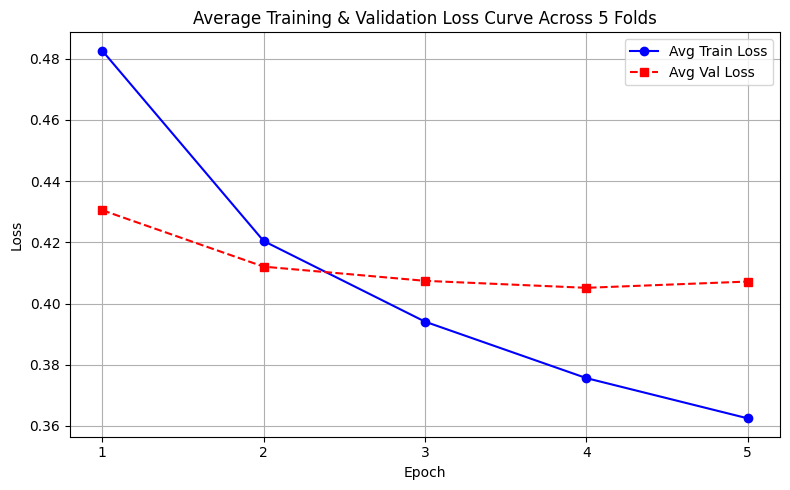


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4826          0.4305          
2       0.4204          0.4120          
3       0.3941          0.4074          
4       0.3756          0.4051          
5       0.3625          0.4072          

Plotting results for experiment: medium



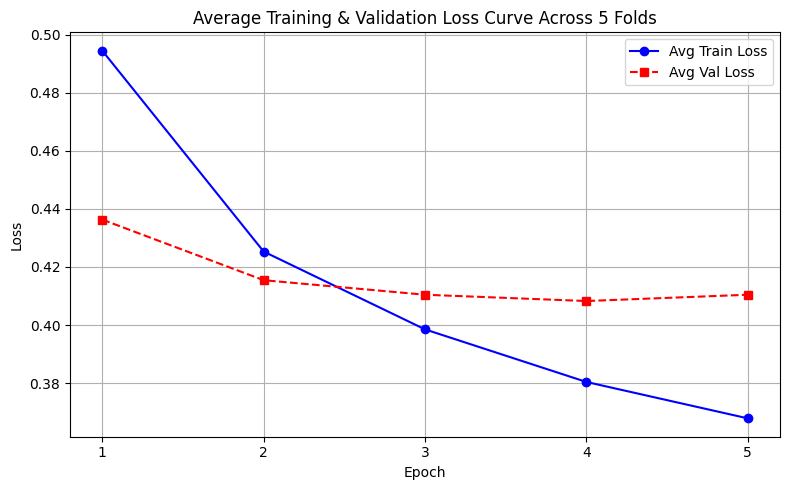


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4945          0.4363          
2       0.4253          0.4155          
3       0.3985          0.4104          
4       0.3804          0.4083          
5       0.3678          0.4104          

Plotting results for experiment: deep



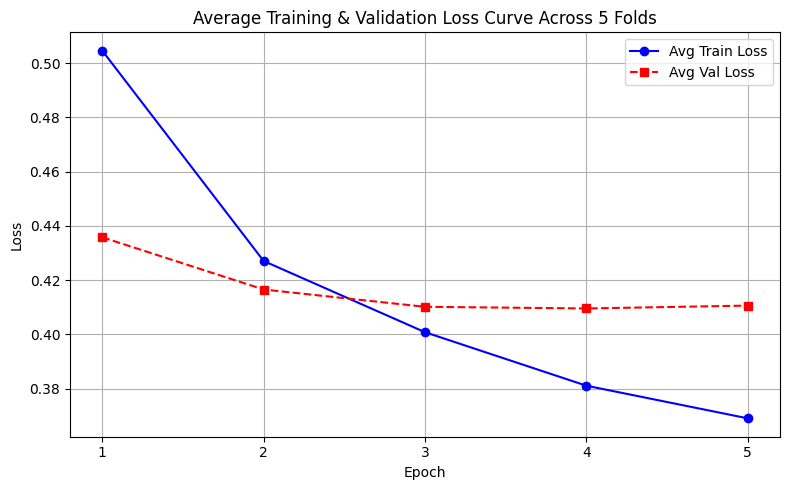


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.5046          0.4358          
2       0.4271          0.4165          
3       0.4008          0.4102          
4       0.3811          0.4096          
5       0.3690          0.4106          

Plotting results for experiment: wide



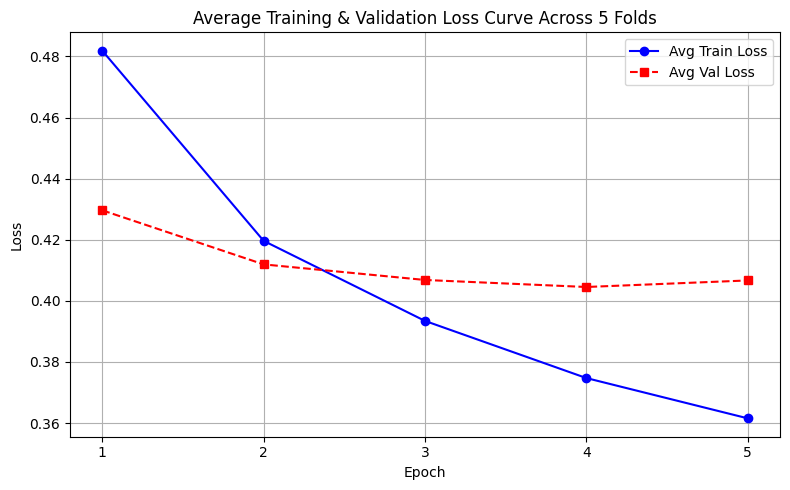


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4819          0.4296          
2       0.4196          0.4119          
3       0.3934          0.4068          
4       0.3747          0.4045          
5       0.3616          0.4067          

Plotting results for experiment: shallow



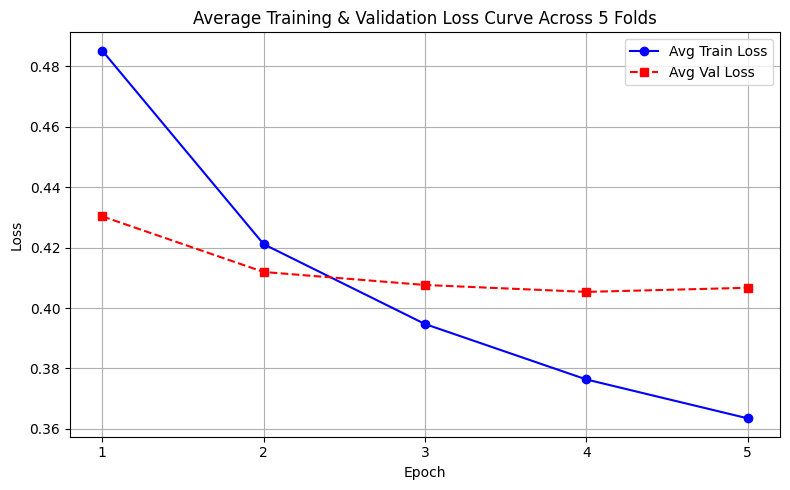


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4851          0.4303          
2       0.4211          0.4119          
3       0.3947          0.4076          
4       0.3764          0.4053          
5       0.3635          0.4067          


In [ ]:
# Plot average training and validation loss curves for 5-fold
plot_avg_loss_across_folds(fold_results_pretrained_model)

for experiment_name, experiment_results in fold_results_custom_model.items():
    print(f"\nPlotting results for experiment: {experiment_name}\n")
    plot_avg_loss_across_folds(experiment_results)

---
# **3.3 Final Model Training**

## Define Final Training Arguments

In [ ]:
def create_final_training_args(model_loader):
    training_args = TrainingArguments(
        output_dir=f"./final_results_{model_loader.__name__}",   # Directory to store checkpoints
        do_train=True,
        report_to="none",                                        # Disable external logging (e.g., WandB)
        eval_strategy="no",                                      # No evaluation during training
        save_strategy="no",                                      # Do not save at each epoch
        per_device_train_batch_size=8,
        num_train_epochs=5,
        learning_rate=3e-5,
        weight_decay=0.01,
        fp16=True,                                               # Enable mixed precision
        gradient_accumulation_steps=16,                          # Accumulate gradients
        logging_dir=f"./final_logs_{model_loader.__name__}",     # Directory for training logs
        logging_strategy="epoch",                                # Log training loss once per epoch
        seed=42                                                  # For reproducibility
    )
    return training_args

## Model Training

In [ ]:
def train_final_model(train_dataset, training_args, model_loader):

    # Train the final model on the full training dataset

    # Load the model using the helper function
    model = model_loader()
    model.to(device)

    # Initialize the Trainer for final training
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics  # Metrics won't be computed during training since evaluation is disabled
    )

    # Start training the final model
    trainer.train()

    return trainer, model

In [ ]:
# Prepare the full training dataset
full_train_dataset = prepare_dataset(x_train, y_train)

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

In [ ]:
# Train the final model using pretrained DistilBert
model_loader = load_pretrained_model
training_args = create_final_training_args(model_loader)
final_pretrained_trainer, final_pretrained_model = train_final_model(full_train_dataset, training_args, model_loader)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-31-e6ccdbd24bf5>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
625,0.421600
1250,0.321100
1875,0.245600
2500,0.181800
3125,0.140800


In [ ]:
best_exp_name = None
best_f1 = -np.inf

print("Average Metrics for Each Experiment:")
for name, results in fold_results_custom_model.items():
    # Extract F1 scores from each fold's average metrics
    f1s = [fold["avg_epoch_metrics"].get("eval_f1", np.nan) for fold in results]
    avg_f1 = np.nanmean(f1s)
    print(f"{name:<10} | Avg F1: {avg_f1:.4f}")

    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_exp_name = name

# Retrieve the best hidden_units configuration from experiments list
best_hidden_units = None
for exp in experiments:
    if exp["name"] == best_exp_name:
        best_hidden_units = exp["hidden_units"]
        break

print(f"\nBest configuration: {best_exp_name} with hidden_units: {best_hidden_units} and avg F1: {best_f1:.4f}")

# Train the final model using custom DistilBert
model_loader = lambda: load_custom_model(hidden_units=best_hidden_units, dropout_rate=0.3, activation=nn.ReLU)
training_args = create_final_training_args(model_loader)
final_custom_trainer, final_custom_model = train_final_model(full_train_dataset, training_args, model_loader)

Average Metrics for Each Experiment:
baseline   | Avg F1: 0.8132
medium     | Avg F1: 0.8126
deep       | Avg F1: 0.8129
wide       | Avg F1: 0.8139
shallow    | Avg F1: 0.8129

Best configuration: wide with hidden_units: [512] and avg F1: 0.8139


<ipython-input-31-e6ccdbd24bf5>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
625,0.472000
1250,0.411700
1875,0.386400
2500,0.368100
3125,0.353400


---
# **3.4 Final Model Evaluation**

In [ ]:
def evaluate_final_model(trainer, eval_dataset):
    final_test_results = trainer.evaluate(eval_dataset)

    # Extract key metrics
    eval_loss = final_test_results.get("eval_loss", "N/A")
    eval_accuracy = final_test_results.get("eval_accuracy", "N/A")
    eval_precision = final_test_results.get("eval_precision", "N/A")
    eval_recall = final_test_results.get("eval_recall", "N/A")
    eval_f1 = final_test_results.get("eval_f1", "N/A")

    print("\nFinal Model Evaluation on the Test Set:")
    print("-" * 50)
    print(f"{'Metric':<15}{'Value':>10}")
    print("-" * 50)
    print(f"{'Accuracy':<15}{eval_accuracy:.4f} ({eval_accuracy * 100:.2f}%)")
    print(f"{'Precision':<15}{eval_precision:.4f} ({eval_precision * 100:.2f}%)")
    print(f"{'Recall':<15}{eval_recall:.4f} ({eval_recall * 100:.2f}%)")
    print(f"{'F1 Score':<15}{eval_f1:.4f} ({eval_f1 * 100:.2f}%)")
    print(f"{'Loss':<15}{eval_loss:.4f}")
    print("-" * 50)

    return final_test_results

In [ ]:
# Prepare the test set
test_dataset = prepare_dataset(x_test, y_test)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [ ]:
# Evaluate the final model using pretrained DistilBert
evaluate_final_model(final_pretrained_trainer, test_dataset)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8299 (82.99%)
Precision      0.8299 (82.99%)
Recall         0.8299 (82.99%)
F1 Score       0.8299 (82.99%)
Loss           0.5317
--------------------------------------------------


{'eval_loss': 0.5317242741584778,
 'eval_accuracy': 0.8299,
 'eval_precision': 0.8299022301390756,
 'eval_recall': 0.8299,
 'eval_f1': 0.8298997125305141,
 'eval_runtime': 23.0889,
 'eval_samples_per_second': 866.215,
 'eval_steps_per_second': 108.277,
 'epoch': 5.0}

In [ ]:
# Evaluate the final model using custom DistilBert
evaluate_final_model(final_custom_trainer, test_dataset)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8197 (81.97%)
Precision      0.8198 (81.98%)
Recall         0.8197 (81.97%)
F1 Score       0.8197 (81.97%)
Loss           0.4035
--------------------------------------------------


{'eval_loss': 0.40346646308898926,
 'eval_accuracy': 0.8197,
 'eval_precision': 0.8198464768925579,
 'eval_recall': 0.8197,
 'eval_f1': 0.8196793550893643,
 'eval_runtime': 22.3616,
 'eval_samples_per_second': 894.392,
 'eval_steps_per_second': 111.799,
 'epoch': 5.0}

---
# **3.5 Final Model Prediction**

## Predict, Compute and Print Evaluation Metrics

In [ ]:
def predict_final_model_with_metrics(trainer, eval_dataset, output_dir=None, class_labels=None):
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids

    # Compute metrics
    accuracy = accuracy_score(true_labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='weighted')

    # Confusion matrix
    cm = confusion_matrix(true_labels, preds)

    # Classification report (per class)
    if class_labels:
        report = classification_report(true_labels, preds, target_names=class_labels, digits=4, output_dict=True)
        report_text = classification_report(true_labels, preds, target_names=class_labels, digits=4)
    else:
        report = classification_report(true_labels, preds, digits=4, output_dict=True)
        report_text = classification_report(true_labels, preds, digits=4)

    # Print summary of metrics
    print("\nFinal Model Predictions Summary")
    print("-" * 50)
    print(f"{'Metric':<15}{'Value':>10}")
    print("-" * 50)
    print(f"{'Accuracy':<15}{accuracy:.4f} ({accuracy * 100:.2f}%)")
    print(f"{'Precision':<15}{precision:.4f} ({precision * 100:.2f}%)")
    print(f"{'Recall':<15}{recall:.4f} ({recall * 100:.2f}%)")
    print(f"{'F1 Score':<15}{f1:.4f} ({f1 * 100:.2f}%)")
    print("-" * 50)

    print("\nClassification Report (Per Class):")
    print(report_text)

    print("\nConfusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(f"{output_dir}/confusion_matrix.png")
        print(f"\nConfusion matrix saved to {output_dir}/confusion_matrix.png\n")
    plt.show()

    metrics = {
        "eval_accuracy": accuracy,
        "eval_precision": precision,
        "eval_recall": recall,
        "eval_f1": f1
    }

    return metrics, cm, preds, true_labels


Final Model Predictions Summary
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8299 (82.99%)
Precision      0.8299 (82.99%)
Recall         0.8299 (82.99%)
F1 Score       0.8299 (82.99%)
--------------------------------------------------

Classification Report (Per Class):
              precision    recall  f1-score   support

    Negative     0.8290    0.8312    0.8301     10000
    Positive     0.8308    0.8286    0.8297     10000

    accuracy                         0.8299     20000
   macro avg     0.8299    0.8299    0.8299     20000
weighted avg     0.8299    0.8299    0.8299     20000


Confusion Matrix:
[[8312 1688]
 [1714 8286]]

Confusion matrix saved to ./1_Initial_Pretrained_Model_Cleaned_Tweets/confusion_matrix.png



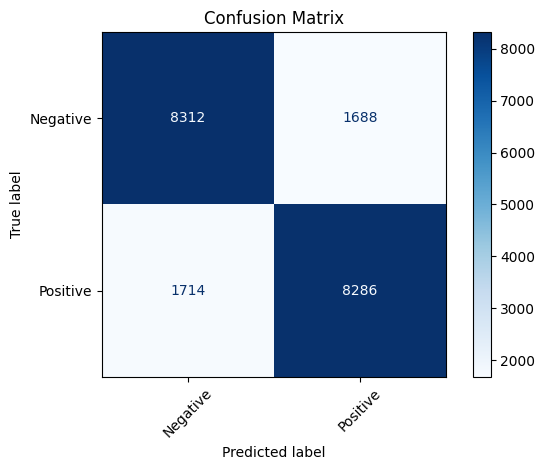

In [ ]:
model_name = "1_Initial_Pretrained_Model_Cleaned_Tweets"

# Get predictions, metrics from confusion matrix and save visualization
prediction_metrics, cm, preds, labels = predict_final_model_with_metrics(
    final_pretrained_trainer,
    test_dataset,
    output_dir=f"./{model_name}",
    class_labels=["Negative", "Positive"]
)


Final Model Predictions Summary
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8197 (81.97%)
Precision      0.8198 (81.98%)
Recall         0.8197 (81.97%)
F1 Score       0.8197 (81.97%)
--------------------------------------------------

Classification Report (Per Class):
              precision    recall  f1-score   support

    Negative     0.8130    0.8304    0.8216     10000
    Positive     0.8267    0.8090    0.8177     10000

    accuracy                         0.8197     20000
   macro avg     0.8198    0.8197    0.8197     20000
weighted avg     0.8198    0.8197    0.8197     20000


Confusion Matrix:
[[8304 1696]
 [1910 8090]]

Confusion matrix saved to ./1_Initial_Custom_Model_Cleaned_Tweets/confusion_matrix.png



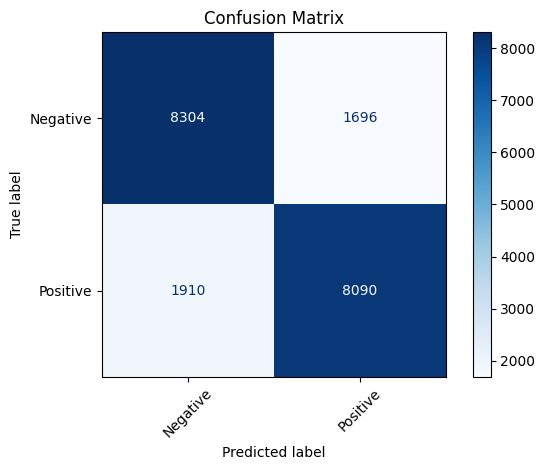

In [ ]:
model_name = "1_Initial_Custom_Model_Cleaned_Tweets"

# Get predictions, metrics from confusion matrix and save visualization
prediction_metrics, cm, preds, labels = predict_final_model_with_metrics(
    final_custom_trainer,
    test_dataset,
    output_dir=f"./{model_name}",
    class_labels=["Negative", "Positive"]
)

---
# **3.6 Save Final Model**

**Note**: If you are running this code chunk, please change the `drive_base_path` to `"/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/DistilBERT"`. If not, you may access the saved model in the `Trained Model Links` file.

In [ ]:
def save_model_to_drive(model, tokenizer, model_name, metrics=None):

    # Mount Google Drive
    drive.mount("/content/drive", force_remount=True)

    # Paths
    local_path = f"./{model_name}"
    drive_base_path = "/content/drive/My Drive/Colab Notebooks/IT1244 Project/Saved Model" # or change to "/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/DistilBERT"
    drive_path = os.path.join(drive_base_path, model_name)

    # Create local directory if it doesn't exist
    if not os.path.exists(local_path):
        os.makedirs(local_path)

    # Save the model and tokenizer locally
    # Check if the model is an instance of a Hugging Face PreTrainedModel
    if isinstance(model, torch.nn.Module):
        # Save the model's state_dict instead of using save_pretrained
        torch.save(model.state_dict(), os.path.join(local_path, "model_state_dict.pth"))
    else:
        model.save_pretrained(local_path)

    tokenizer.save_pretrained(local_path)

    # Save metrics to local folder
    if metrics:
        with open(os.path.join(local_path, "metrics.json"), "w") as f:
            json.dump(metrics, f, indent=4)

    # Remove old copy in Google Drive (if exists)
    if os.path.exists(drive_path):
        try:
            shutil.rmtree(drive_path)
        except Exception as e:
            print(f"Error removing existing folder {drive_path}: {e}")

    # Copy local folder to Google Drive
    try:
        shutil.copytree(local_path, drive_path)
        print(f"Model and metrics saved to Google Drive at: {drive_path}")
    except Exception as e:
        print(f"Error copying model to Google Drive: {e}")

In [ ]:
model_name = "1_Initial_Pretrained_Model_Cleaned_Tweets"
final_model_eval_metrics = evaluate_final_model(final_pretrained_trainer, test_dataset)
metrics1 = {
    "trainer_evaluation": final_model_eval_metrics,
    "confusion_matrix_metrics": prediction_metrics
}
save_model_to_drive(final_pretrained_model, tokenizer, model_name, metrics=metrics1)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8299 (82.99%)
Precision      0.8299 (82.99%)
Recall         0.8299 (82.99%)
F1 Score       0.8299 (82.99%)
Loss           0.5317
--------------------------------------------------
Mounted at /content/drive
Model and metrics saved to Google Drive at: /content/drive/My Drive/Colab Notebooks/IT1244 Project/Saved Model/1_Initial_Pretrained_Model_Cleaned_Tweets


In [ ]:
model_name = "1_Initial_Custom_Model_Cleaned_Tweets"
final_model_eval_metrics = evaluate_final_model(final_custom_trainer, test_dataset)
metrics2 = {
    "trainer_evaluation": final_model_eval_metrics,
    "confusion_matrix_metrics": prediction_metrics
}
save_model_to_drive(final_custom_model, tokenizer, model_name, metrics=metrics2)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8197 (81.97%)
Precision      0.8198 (81.98%)
Recall         0.8197 (81.97%)
F1 Score       0.8197 (81.97%)
Loss           0.4035
--------------------------------------------------
Mounted at /content/drive
Model and metrics saved to Google Drive at: /content/drive/My Drive/Colab Notebooks/IT1244 Project/Saved Model/1_Initial_Custom_Model_Cleaned_Tweets


---
# **4. Hyperparameter Fine-Tuning Using Optuna**

---
# **4.1 Fine-Tuned Model Training & Evaluation**

## Helper Function: Run just the first fold

In [ ]:
def run_first_fold(x_train, y_train, training_args, model_loader):
    # Create a StratifiedKFold object with 5 splits
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Loop over the folds, but break after the first one
    for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train, y_train)):
        print(f"\nRunning Fold {fold + 1}/1 (only the first fold will be used)")

        # Split data for this fold
        fold_x_train, fold_x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
        fold_y_train, fold_y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train and evaluate on this fold
        result = run_fold(fold, fold_x_train, fold_y_train, fold_x_val, fold_y_val, training_args, model_loader)

        # Return the result of the first fold and exit
        return result

## Define Base Training Arguments for Hyperparameter Search

In [ ]:
def create_base_training_args(
    model_loader,
    learning_rate,
    batch_size,
    grad_acc,
    weight_decay,
    warmup_steps,
    max_grad_norm,
    adam_epsilon,
    scheduler_choice
):
    return TrainingArguments(
        output_dir=f"./base_results_{model_loader.__name__}",
        report_to="none",
        eval_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=5,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        fp16=True,
        gradient_accumulation_steps=grad_acc,
        logging_dir=f"./base_logs_{model_loader.__name__}",
        logging_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        seed=42,
        warmup_steps=warmup_steps,
        max_grad_norm=max_grad_norm,
        adam_epsilon=adam_epsilon,
        lr_scheduler_type=scheduler_choice
    )

## Objective for Optuna

In [ ]:
def optuna_objective_distilbert(trial):
    # Training hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    grad_acc = trial.suggest_categorical("grad_acc", [1, 4, 8, 16])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
    warmup_steps = trial.suggest_int("warmup_steps", 0, 500)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.5, 2.0)
    adam_epsilon = trial.suggest_float("adam_epsilon", 1e-8, 1e-6, log=True)
    scheduler_choice = trial.suggest_categorical("scheduler", ["linear", "cosine", "constant"])

    model_loader = load_pretrained_model

    # Update training arguments with trial-suggested values
    training_args = create_base_training_args(
        model_loader=model_loader,
        learning_rate=learning_rate,
        batch_size=batch_size,
        grad_acc=grad_acc,
        weight_decay=weight_decay,
        warmup_steps=warmup_steps,
        max_grad_norm=max_grad_norm,
        adam_epsilon=adam_epsilon,
        scheduler_choice=scheduler_choice
    )

    # Run only the first fold for quicker evaluation
    result = run_first_fold(x_train, y_train, training_args, model_loader)

    # Extract average evaluation metrics from the first fold
    avg_metrics = result["avg_epoch_metrics"]
    print("\nTrial Summary:")
    for metric, value in avg_metrics.items():
        print(f"{metric:<15}: {value:.4f}")

    # Store metrics for further analysis
    trial.set_user_attr("metrics", avg_metrics)

    # Return F1 as the objective metric to maximize
    return avg_metrics["eval_f1"]

In [ ]:
def optuna_objective_custom_model(trial):
    # Architecture parameters
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_units = [trial.suggest_categorical(f"hidden_size_{i}", [64, 128, 256, 512])
                    for i in range(n_layers)]

    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    activation_choice = trial.suggest_categorical("activation", ["relu", "gelu", "tanh"])

    # Training hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    grad_acc = trial.suggest_categorical("grad_acc", [1, 4, 8, 16])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
    warmup_steps = trial.suggest_int("warmup_steps", 0, 500)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.5, 2.0)
    adam_epsilon = trial.suggest_float("adam_epsilon", 1e-8, 1e-6, log=True)
    scheduler_choice = trial.suggest_categorical("scheduler", ["linear", "cosine", "constant"])

    # Map activation function string to torch.nn module
    activation_map = {
        "relu": nn.ReLU,
        "gelu": nn.GELU,
        "tanh": nn.Tanh
    }

    # Model loader using the current trial's architecture parameters
    model_loader = lambda: load_custom_model(
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        activation=activation_map[activation_choice]
    )

    # Update training arguments with trial-suggested values
    training_args = create_base_training_args(
        model_loader=model_loader,
        learning_rate=learning_rate,
        batch_size=batch_size,
        grad_acc=grad_acc,
        weight_decay=weight_decay,
        warmup_steps=warmup_steps,
        max_grad_norm=max_grad_norm,
        adam_epsilon=adam_epsilon,
        scheduler_choice=scheduler_choice
    )

    # Run only the first fold for quicker evaluation
    result = run_first_fold(x_train, y_train, training_args, model_loader)

    # Extract average evaluation metrics from the first fold
    avg_metrics = result["avg_epoch_metrics"]
    print("\nTrial Summary:")
    for metric, value in avg_metrics.items():
        print(f"{metric:<15}: {value:.4f}")

    # Store metrics for further analysis
    trial.set_user_attr("metrics", avg_metrics)

    # Return F1 as the objective metric to maximize
    return avg_metrics["eval_f1"]

**WARNING**: Running the below code chunk will take approximately 3 hours on GPU

In [ ]:
# Run Optuna Study for Pretrained DistilBert
study1 = optuna.create_study(direction="maximize", study_name="custom_model_optuna_tuning")
study1.optimize(optuna_objective_distilbert, n_trials=15)

print("\nBest Trial:")
print(f"Best F1 Score: {study1.best_value:.4f}")
for key, value in study1.best_trial.params.items():
    print(f"{key:<25}: {value}")

[I 2025-03-29 09:41:54,636] A new study created in memory with name: custom_model_optuna_tuning



Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.426400,0.376785,0.831500,0.831507,0.831500,0.831499
2,0.317200,0.390321,0.831750,0.831945,0.831750,0.831725
3,0.223300,0.452300,0.831250,0.831360,0.831250,0.831236
4,0.146900,0.616030,0.823937,0.824176,0.823937,0.823905


[I 2025-03-29 09:49:59,434] Trial 0 finished with value: 0.8295913417868 and parameters: {'learning_rate': 2.574663409239766e-05, 'batch_size': 16, 'grad_acc': 4, 'weight_decay': 0.08934767798906779, 'warmup_steps': 278, 'max_grad_norm': 0.9161014358589501, 'adam_epsilon': 8.731252038176818e-08, 'scheduler': 'constant'}. Best is trial 0 with value: 0.8295913417868.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4589
eval_accuracy            : 0.8296
eval_precision           : 0.8297
eval_recall              : 0.8296
eval_f1                  : 0.8296
eval_runtime             : 10.5602
eval_samples_per_second  : 1515.1408
eval_steps_per_second    : 94.6962

Loss History:
- Training Loss per Epoch   : ['0.4264', '0.3172', '0.2233', '0.1469']
- Validation Loss per Epoch : ['0.3768', '0.3903', '0.4523', '0.6160']
- Average Training Loss     : 0.2785
- Average Validation Loss   : 0.4589

Trial Summary:
eval_loss      : 0.4589
eval_accuracy  : 0.8296
eval_precision : 0.8297
eval_recall    : 0.8296
eval_f1        : 0.8296
eval_runtime   : 10.5602
eval_samples_per_second: 1515.1408
eval_steps_per_second: 94.6962

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.435200,0.390483,0.826438,0.826660,0.826438,0.826408
2,0.340300,0.434575,0.831438,0.831565,0.831438,0.831421
3,0.269700,0.685268,0.827750,0.827951,0.827750,0.827724
4,0.202900,0.753256,0.823125,0.825868,0.823125,0.822752


[I 2025-03-29 10:07:08,064] Trial 1 finished with value: 0.8270761861984686 and parameters: {'learning_rate': 1.537360698888855e-05, 'batch_size': 8, 'grad_acc': 1, 'weight_decay': 0.011637560843953976, 'warmup_steps': 63, 'max_grad_norm': 1.563536173644693, 'adam_epsilon': 1.4822255209021499e-08, 'scheduler': 'constant'}. Best is trial 0 with value: 0.8295913417868.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.5659
eval_accuracy            : 0.8272
eval_precision           : 0.8280
eval_recall              : 0.8272
eval_f1                  : 0.8271
eval_runtime             : 18.2817
eval_samples_per_second  : 875.2068
eval_steps_per_second    : 109.4007

Loss History:
- Training Loss per Epoch   : ['0.4352', '0.3403', '0.2697', '0.2029']
- Validation Loss per Epoch : ['0.3905', '0.4346', '0.6853', '0.7533']
- Average Training Loss     : 0.3120
- Average Validation Loss   : 0.5659

Trial Summary:
eval_loss      : 0.5659
eval_accuracy  : 0.8272
eval_precision : 0.8280
eval_recall    : 0.8272
eval_f1        : 0.8271
eval_runtime   : 18.2817
eval_samples_per_second: 875.2068
eval_steps_per_second: 109.4007

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.471500,0.386608,0.828250,0.828251,0.828250,0.828250
2,0.348000,0.382180,0.834625,0.834705,0.834625,0.834615
3,0.271000,0.409679,0.835562,0.835709,0.835562,0.835545
4,0.210100,0.443607,0.835375,0.835376,0.835375,0.835375
5,0.177700,0.478298,0.833688,0.833688,0.833688,0.833687


[I 2025-03-29 10:12:49,335] Trial 2 finished with value: 0.8334943970049485 and parameters: {'learning_rate': 2.2856800670315072e-05, 'batch_size': 32, 'grad_acc': 4, 'weight_decay': 0.04814916233966323, 'warmup_steps': 215, 'max_grad_norm': 1.1392799056920588, 'adam_epsilon': 4.226567100421813e-07, 'scheduler': 'cosine'}. Best is trial 2 with value: 0.8334943970049485.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4201
eval_accuracy            : 0.8335
eval_precision           : 0.8335
eval_recall              : 0.8335
eval_f1                  : 0.8335
eval_runtime             : 6.6624
eval_samples_per_second  : 2401.7558
eval_steps_per_second    : 75.0550

Loss History:
- Training Loss per Epoch   : ['0.4715', '0.3480', '0.2710', '0.2101', '0.1777']
- Validation Loss per Epoch : ['0.3866', '0.3822', '0.4097', '0.4436', '0.4783']
- Average Training Loss     : 0.2957
- Average Validation Loss   : 0.4201

Trial Summary:
eval_loss      : 0.4201
eval_accuracy  : 0.8335
eval_precision : 0.8335
eval_recall    : 0.8335
eval_f1        : 0.8335
eval_runtime   : 6.6624
eval_samples_per_second: 2401.7558
eval_steps_per_second: 75.0550

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.464000,0.381982,0.829313,0.829446,0.829313,0.829295
2,0.332400,0.382503,0.832438,0.832440,0.832438,0.832437
3,0.235300,0.436176,0.834500,0.834602,0.834500,0.834487
4,0.155300,0.507019,0.828937,0.828939,0.828937,0.828937
5,0.118600,0.563058,0.829875,0.829885,0.829875,0.829874


[I 2025-03-29 10:22:35,196] Trial 3 finished with value: 0.8310061550125851 and parameters: {'learning_rate': 3.3767366137044196e-05, 'batch_size': 16, 'grad_acc': 8, 'weight_decay': 0.2678098335843901, 'warmup_steps': 211, 'max_grad_norm': 0.7650302480747614, 'adam_epsilon': 1.2969726557612313e-07, 'scheduler': 'cosine'}. Best is trial 2 with value: 0.8334943970049485.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4541
eval_accuracy            : 0.8310
eval_precision           : 0.8311
eval_recall              : 0.8310
eval_f1                  : 0.8310
eval_runtime             : 10.5673
eval_samples_per_second  : 1514.3072
eval_steps_per_second    : 94.6442

Loss History:
- Training Loss per Epoch   : ['0.4640', '0.3324', '0.2353', '0.1553', '0.1186']
- Validation Loss per Epoch : ['0.3820', '0.3825', '0.4362', '0.5070', '0.5631']
- Average Training Loss     : 0.2611
- Average Validation Loss   : 0.4541

Trial Summary:
eval_loss      : 0.4541
eval_accuracy  : 0.8310
eval_precision : 0.8311
eval_recall    : 0.8310
eval_f1        : 0.8310
eval_runtime   : 10.5673
eval_samples_per_second: 1514.3072
eval_steps_per_second: 94.6442

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.459300,0.396505,0.823313,0.823447,0.823313,0.823294
2,0.372100,0.385249,0.829250,0.829432,0.829250,0.829226
3,0.327500,0.392693,0.830250,0.830406,0.830250,0.830230
4,0.286100,0.398019,0.834000,0.834209,0.834000,0.833974
5,0.243500,0.428776,0.831375,0.831381,0.831375,0.831374


[I 2025-03-29 10:39:57,264] Trial 4 finished with value: 0.8296197604322721 and parameters: {'learning_rate': 1.001742855548385e-05, 'batch_size': 8, 'grad_acc': 16, 'weight_decay': 0.022038728536505448, 'warmup_steps': 301, 'max_grad_norm': 1.674989430779125, 'adam_epsilon': 2.765385498762505e-08, 'scheduler': 'constant'}. Best is trial 2 with value: 0.8334943970049485.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4002
eval_accuracy            : 0.8296
eval_precision           : 0.8298
eval_recall              : 0.8296
eval_f1                  : 0.8296
eval_runtime             : 18.3123
eval_samples_per_second  : 873.7620
eval_steps_per_second    : 109.2202

Loss History:
- Training Loss per Epoch   : ['0.4593', '0.3721', '0.3275', '0.2861', '0.2435']
- Validation Loss per Epoch : ['0.3965', '0.3852', '0.3927', '0.3980', '0.4288']
- Average Training Loss     : 0.3377
- Average Validation Loss   : 0.4002

Trial Summary:
eval_loss      : 0.4002
eval_accuracy  : 0.8296
eval_precision : 0.8298
eval_recall    : 0.8296
eval_f1        : 0.8296
eval_runtime   : 18.3123
eval_samples_per_second: 873.7620
eval_steps_per_second: 109.2202

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.448400,0.379688,0.831750,0.831757,0.831750,0.831749
2,0.321200,0.385156,0.834688,0.834786,0.834688,0.834675
3,0.227900,0.439200,0.833812,0.834058,0.833812,0.833782
4,0.154600,0.508446,0.828438,0.829224,0.828438,0.828335


[I 2025-03-29 10:44:32,304] Trial 5 finished with value: 0.8321353589909523 and parameters: {'learning_rate': 3.687053463320062e-05, 'batch_size': 32, 'grad_acc': 4, 'weight_decay': 0.20724871842416961, 'warmup_steps': 111, 'max_grad_norm': 1.0391421610296845, 'adam_epsilon': 1.5490644029126393e-07, 'scheduler': 'linear'}. Best is trial 2 with value: 0.8334943970049485.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4281
eval_accuracy            : 0.8322
eval_precision           : 0.8325
eval_recall              : 0.8322
eval_f1                  : 0.8321
eval_runtime             : 6.6886
eval_samples_per_second  : 2392.3043
eval_steps_per_second    : 74.7595

Loss History:
- Training Loss per Epoch   : ['0.4484', '0.3212', '0.2279', '0.1546']
- Validation Loss per Epoch : ['0.3797', '0.3852', '0.4392', '0.5084']
- Average Training Loss     : 0.2880
- Average Validation Loss   : 0.4281

Trial Summary:
eval_loss      : 0.4281
eval_accuracy  : 0.8322
eval_precision : 0.8325
eval_recall    : 0.8322
eval_f1        : 0.8321
eval_runtime   : 6.6886
eval_samples_per_second: 2392.3043
eval_steps_per_second: 74.7595

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.432800,0.385804,0.824625,0.828209,0.824625,0.824145
2,0.313300,0.405840,0.834688,0.835401,0.834688,0.834600
3,0.215300,0.503514,0.833500,0.833762,0.833500,0.833467
4,0.142100,0.670413,0.830750,0.830750,0.830750,0.830750


[I 2025-03-29 10:53:48,452] Trial 6 finished with value: 0.830740441844406 and parameters: {'learning_rate': 1.7365072048834852e-05, 'batch_size': 16, 'grad_acc': 1, 'weight_decay': 0.2876115737455573, 'warmup_steps': 320, 'max_grad_norm': 1.9134001109733862, 'adam_epsilon': 9.72633147215026e-07, 'scheduler': 'cosine'}. Best is trial 2 with value: 0.8334943970049485.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4914
eval_accuracy            : 0.8309
eval_precision           : 0.8320
eval_recall              : 0.8309
eval_f1                  : 0.8307
eval_runtime             : 10.5106
eval_samples_per_second  : 1522.2965
eval_steps_per_second    : 95.1435

Loss History:
- Training Loss per Epoch   : ['0.4328', '0.3133', '0.2153', '0.1421']
- Validation Loss per Epoch : ['0.3858', '0.4058', '0.5035', '0.6704']
- Average Training Loss     : 0.2759
- Average Validation Loss   : 0.4914

Trial Summary:
eval_loss      : 0.4914
eval_accuracy  : 0.8309
eval_precision : 0.8320
eval_recall    : 0.8309
eval_f1        : 0.8307
eval_runtime   : 10.5106
eval_samples_per_second: 1522.2965
eval_steps_per_second: 95.1435

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.451200,0.380456,0.830750,0.831384,0.830750,0.830669
2,0.318800,0.395220,0.831875,0.832231,0.831875,0.831830
3,0.204900,0.477328,0.828375,0.829056,0.828375,0.828286
4,0.119300,0.596131,0.827875,0.827876,0.827875,0.827875


[I 2025-03-29 11:07:58,656] Trial 7 finished with value: 0.8296649774355078 and parameters: {'learning_rate': 3.881179163621427e-05, 'batch_size': 8, 'grad_acc': 8, 'weight_decay': 0.16006423756220775, 'warmup_steps': 409, 'max_grad_norm': 0.736779082040919, 'adam_epsilon': 2.5321404194059475e-07, 'scheduler': 'linear'}. Best is trial 2 with value: 0.8334943970049485.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4623
eval_accuracy            : 0.8297
eval_precision           : 0.8301
eval_recall              : 0.8297
eval_f1                  : 0.8297
eval_runtime             : 18.2274
eval_samples_per_second  : 877.8232
eval_steps_per_second    : 109.7280

Loss History:
- Training Loss per Epoch   : ['0.4512', '0.3188', '0.2049', '0.1193']
- Validation Loss per Epoch : ['0.3805', '0.3952', '0.4773', '0.5961']
- Average Training Loss     : 0.2736
- Average Validation Loss   : 0.4623

Trial Summary:
eval_loss      : 0.4623
eval_accuracy  : 0.8297
eval_precision : 0.8301
eval_recall    : 0.8297
eval_f1        : 0.8297
eval_runtime   : 18.2274
eval_samples_per_second: 877.8232
eval_steps_per_second: 109.7280

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.434300,0.385383,0.828625,0.829687,0.828625,0.828487
2,0.333200,0.391910,0.834562,0.834627,0.834562,0.834555
3,0.264700,0.424481,0.833625,0.833625,0.833625,0.833625
4,0.207900,0.473236,0.832187,0.832206,0.832187,0.832185


[I 2025-03-29 11:22:36,700] Trial 8 finished with value: 0.8322129151613231 and parameters: {'learning_rate': 1.3224373635601065e-05, 'batch_size': 8, 'grad_acc': 4, 'weight_decay': 0.2261710742052245, 'warmup_steps': 85, 'max_grad_norm': 1.4717838911687253, 'adam_epsilon': 1.578059213189378e-07, 'scheduler': 'linear'}. Best is trial 2 with value: 0.8334943970049485.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4188
eval_accuracy            : 0.8322
eval_precision           : 0.8325
eval_recall              : 0.8322
eval_f1                  : 0.8322
eval_runtime             : 18.2153
eval_samples_per_second  : 878.3925
eval_steps_per_second    : 109.7990

Loss History:
- Training Loss per Epoch   : ['0.4343', '0.3332', '0.2647', '0.2079']
- Validation Loss per Epoch : ['0.3854', '0.3919', '0.4245', '0.4732']
- Average Training Loss     : 0.3100
- Average Validation Loss   : 0.4188

Trial Summary:
eval_loss      : 0.4188
eval_accuracy  : 0.8322
eval_precision : 0.8325
eval_recall    : 0.8322
eval_f1        : 0.8322
eval_runtime   : 18.2153
eval_samples_per_second: 878.3925
eval_steps_per_second: 109.7990

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.454400,0.405954,0.819187,0.819284,0.819187,0.819174
2,0.352200,0.492558,0.824812,0.825186,0.824812,0.824762
3,0.265200,0.687062,0.824375,0.824424,0.824375,0.824368
4,0.168600,0.965923,0.821688,0.821743,0.821688,0.821680


[I 2025-03-29 11:39:45,792] Trial 9 finished with value: 0.8224960780029593 and parameters: {'learning_rate': 3.785494895277757e-05, 'batch_size': 8, 'grad_acc': 1, 'weight_decay': 0.14995342140865445, 'warmup_steps': 418, 'max_grad_norm': 1.0096918956621228, 'adam_epsilon': 1.1597075601561331e-07, 'scheduler': 'linear'}. Best is trial 2 with value: 0.8334943970049485.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.6379
eval_accuracy            : 0.8225
eval_precision           : 0.8227
eval_recall              : 0.8225
eval_f1                  : 0.8225
eval_runtime             : 18.3131
eval_samples_per_second  : 873.7223
eval_steps_per_second    : 109.2150

Loss History:
- Training Loss per Epoch   : ['0.4544', '0.3522', '0.2652', '0.1686']
- Validation Loss per Epoch : ['0.4060', '0.4926', '0.6871', '0.9659']
- Average Training Loss     : 0.3101
- Average Validation Loss   : 0.6379

Trial Summary:
eval_loss      : 0.6379
eval_accuracy  : 0.8225
eval_precision : 0.8227
eval_recall    : 0.8225
eval_f1        : 0.8225
eval_runtime   : 18.3131
eval_samples_per_second: 873.7223
eval_steps_per_second: 109.2150

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.587200,0.434648,0.802063,0.802201,0.802063,0.802040
2,0.412700,0.391042,0.825187,0.825583,0.825187,0.825134
3,0.352900,0.385201,0.831375,0.831485,0.831375,0.831361
4,0.304700,0.391309,0.835250,0.835284,0.835250,0.835246
5,0.275800,0.406853,0.834000,0.834002,0.834000,0.834000


[I 2025-03-29 11:45:12,214] Trial 10 finished with value: 0.8255561595261092 and parameters: {'learning_rate': 2.425178681361542e-05, 'batch_size': 32, 'grad_acc': 16, 'weight_decay': 0.07542025545054637, 'warmup_steps': 213, 'max_grad_norm': 0.5141048173488401, 'adam_epsilon': 9.679070275678541e-07, 'scheduler': 'cosine'}. Best is trial 2 with value: 0.8334943970049485.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4018
eval_accuracy            : 0.8256
eval_precision           : 0.8257
eval_recall              : 0.8256
eval_f1                  : 0.8256
eval_runtime             : 6.7076
eval_samples_per_second  : 2385.4976
eval_steps_per_second    : 74.5470

Loss History:
- Training Loss per Epoch   : ['0.5872', '0.4127', '0.3529', '0.3047', '0.2758']
- Validation Loss per Epoch : ['0.4346', '0.3910', '0.3852', '0.3913', '0.4069']
- Average Training Loss     : 0.3867
- Average Validation Loss   : 0.4018

Trial Summary:
eval_loss      : 0.4018
eval_accuracy  : 0.8256
eval_precision : 0.8257
eval_recall    : 0.8256
eval_f1        : 0.8256
eval_runtime   : 6.7076
eval_samples_per_second: 2385.4976
eval_steps_per_second: 74.5470

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.459700,0.396802,0.822625,0.822721,0.822625,0.822612
2,0.371000,0.387001,0.830187,0.830342,0.830187,0.830168
3,0.329700,0.388160,0.833313,0.833317,0.833313,0.833312
4,0.302100,0.394474,0.832875,0.832889,0.832875,0.832873
5,0.288200,0.401134,0.833063,0.833075,0.833063,0.833061


[I 2025-03-29 11:50:54,697] Trial 11 finished with value: 0.8304051140550939 and parameters: {'learning_rate': 1.063369120685201e-05, 'batch_size': 32, 'grad_acc': 4, 'weight_decay': 0.23514152660717924, 'warmup_steps': 7, 'max_grad_norm': 1.3148310558133456, 'adam_epsilon': 3.854120262230719e-07, 'scheduler': 'cosine'}. Best is trial 2 with value: 0.8334943970049485.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.3935
eval_accuracy            : 0.8304
eval_precision           : 0.8305
eval_recall              : 0.8304
eval_f1                  : 0.8304
eval_runtime             : 6.5935
eval_samples_per_second  : 2426.6620
eval_steps_per_second    : 75.8334

Loss History:
- Training Loss per Epoch   : ['0.4597', '0.3710', '0.3297', '0.3021', '0.2882']
- Validation Loss per Epoch : ['0.3968', '0.3870', '0.3882', '0.3945', '0.4011']
- Average Training Loss     : 0.3501
- Average Validation Loss   : 0.3935

Trial Summary:
eval_loss      : 0.3935
eval_accuracy  : 0.8304
eval_precision : 0.8305
eval_recall    : 0.8304
eval_f1        : 0.8304
eval_runtime   : 6.5935
eval_samples_per_second: 2426.6620
eval_steps_per_second: 75.8334

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.472600,0.389268,0.826063,0.826065,0.826063,0.826062
2,0.357300,0.384107,0.831438,0.831549,0.831438,0.831423
3,0.302600,0.393345,0.835063,0.835164,0.835063,0.835050
4,0.261100,0.407964,0.834313,0.834495,0.834313,0.834290
5,0.231800,0.431335,0.834500,0.834519,0.834500,0.834498


[I 2025-03-29 11:56:37,976] Trial 12 finished with value: 0.8322645997564398 and parameters: {'learning_rate': 1.6664396325666243e-05, 'batch_size': 32, 'grad_acc': 4, 'weight_decay': 0.1717800859822927, 'warmup_steps': 153, 'max_grad_norm': 1.3193236333459064, 'adam_epsilon': 3.688534840136354e-07, 'scheduler': 'linear'}. Best is trial 2 with value: 0.8334943970049485.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4012
eval_accuracy            : 0.8323
eval_precision           : 0.8324
eval_recall              : 0.8323
eval_f1                  : 0.8323
eval_runtime             : 6.6979
eval_samples_per_second  : 2388.9410
eval_steps_per_second    : 74.6546

Loss History:
- Training Loss per Epoch   : ['0.4726', '0.3573', '0.3026', '0.2611', '0.2318']
- Validation Loss per Epoch : ['0.3893', '0.3841', '0.3933', '0.4080', '0.4313']
- Average Training Loss     : 0.3251
- Average Validation Loss   : 0.4012

Trial Summary:
eval_loss      : 0.4012
eval_accuracy  : 0.8323
eval_precision : 0.8324
eval_recall    : 0.8323
eval_f1        : 0.8323
eval_runtime   : 6.6979
eval_samples_per_second: 2388.9410
eval_steps_per_second: 74.6546

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.468400,0.386982,0.827750,0.827795,0.827750,0.827744
2,0.350700,0.384574,0.831875,0.832005,0.831875,0.831859
3,0.289700,0.397586,0.836063,0.836118,0.836063,0.836056
4,0.242100,0.419418,0.833438,0.833740,0.833438,0.833400
5,0.208500,0.449726,0.833250,0.833258,0.833250,0.833249


[I 2025-03-29 12:02:20,913] Trial 13 finished with value: 0.8324614047391001 and parameters: {'learning_rate': 1.95668561196393e-05, 'batch_size': 32, 'grad_acc': 4, 'weight_decay': 0.12943044527851663, 'warmup_steps': 157, 'max_grad_norm': 1.231400522352126, 'adam_epsilon': 4.3637345502770716e-07, 'scheduler': 'linear'}. Best is trial 2 with value: 0.8334943970049485.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4077
eval_accuracy            : 0.8325
eval_precision           : 0.8326
eval_recall              : 0.8325
eval_f1                  : 0.8325
eval_runtime             : 6.6663
eval_samples_per_second  : 2400.1524
eval_steps_per_second    : 75.0048

Loss History:
- Training Loss per Epoch   : ['0.4684', '0.3507', '0.2897', '0.2421', '0.2085']
- Validation Loss per Epoch : ['0.3870', '0.3846', '0.3976', '0.4194', '0.4497']
- Average Training Loss     : 0.3119
- Average Validation Loss   : 0.4077

Trial Summary:
eval_loss      : 0.4077
eval_accuracy  : 0.8325
eval_precision : 0.8326
eval_recall    : 0.8325
eval_f1        : 0.8325
eval_runtime   : 6.6663
eval_samples_per_second: 2400.1524
eval_steps_per_second: 75.0048

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.469200,0.386272,0.828562,0.828584,0.828562,0.828560
2,0.347800,0.384434,0.832750,0.832846,0.832750,0.832738
3,0.276100,0.402191,0.836187,0.836248,0.836187,0.836180
4,0.220500,0.432801,0.834063,0.834063,0.834063,0.834062
5,0.191100,0.457280,0.834313,0.834313,0.834313,0.834312


[I 2025-03-29 12:08:04,278] Trial 14 finished with value: 0.833170541254115 and parameters: {'learning_rate': 2.0990240330155073e-05, 'batch_size': 32, 'grad_acc': 4, 'weight_decay': 0.09430500021438518, 'warmup_steps': 177, 'max_grad_norm': 1.179140235419196, 'adam_epsilon': 6.334420109691782e-08, 'scheduler': 'cosine'}. Best is trial 2 with value: 0.8334943970049485.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4126
eval_accuracy            : 0.8332
eval_precision           : 0.8332
eval_recall              : 0.8332
eval_f1                  : 0.8332
eval_runtime             : 6.6603
eval_samples_per_second  : 2402.4584
eval_steps_per_second    : 75.0768

Loss History:
- Training Loss per Epoch   : ['0.4692', '0.3478', '0.2761', '0.2205', '0.1911']
- Validation Loss per Epoch : ['0.3863', '0.3844', '0.4022', '0.4328', '0.4573']
- Average Training Loss     : 0.3009
- Average Validation Loss   : 0.4126

Trial Summary:
eval_loss      : 0.4126
eval_accuracy  : 0.8332
eval_precision : 0.8332
eval_recall    : 0.8332
eval_f1        : 0.8332
eval_runtime   : 6.6603
eval_samples_per_second: 2402.4584
eval_steps_per_second: 75.0768

Best Trial:
Best F1 Score: 0.8335
learning_rate            : 2.2856800670315072e-05
batch_size               : 32
grad_acc                 : 4
weig

**WARNING**: Running the below code chunk will take approximately 3 hours on GPU

In [ ]:
# Run Optuna Study for Custom Model
study2 = optuna.create_study(direction="maximize", study_name="custom_model_optuna_tuning")
study2.optimize(optuna_objective_custom_model, n_trials=15)

print("\nBest Trial:")
print(f"Best F1 Score: {study2.best_value:.4f}")
for key, value in study2.best_trial.params.items():
    print(f"{key:<25}: {value}")

[I 2025-03-29 12:08:04,284] A new study created in memory with name: custom_model_optuna_tuning



Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.609500,0.464378,0.780500,0.780854,0.780500,0.780431
2,0.453500,0.427560,0.802375,0.802700,0.802375,0.802322
3,0.423500,0.414287,0.811187,0.811188,0.811187,0.811187
4,0.407400,0.410975,0.813688,0.813992,0.813688,0.813642
5,0.401400,0.410399,0.813187,0.813192,0.813187,0.813187


[I 2025-03-29 12:11:57,445] Trial 0 finished with value: 0.8041538925092888 and parameters: {'n_layers': 2, 'hidden_size_0': 512, 'hidden_size_1': 64, 'dropout_rate': 0.15397552462454175, 'activation': 'relu', 'learning_rate': 3.0299185684010088e-05, 'batch_size': 32, 'grad_acc': 16, 'weight_decay': 0.11628070206714124, 'warmup_steps': 94, 'max_grad_norm': 1.2457913639230662, 'adam_epsilon': 3.028542388677978e-07, 'scheduler': 'cosine'}. Best is trial 0 with value: 0.8041538925092888.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4255
eval_accuracy            : 0.8042
eval_precision           : 0.8044
eval_recall              : 0.8042
eval_f1                  : 0.8042
eval_runtime             : 6.6083
eval_samples_per_second  : 2421.2074
eval_steps_per_second    : 75.6626

Loss History:
- Training Loss per Epoch   : ['0.6095', '0.4535', '0.4235', '0.4074', '0.4014']
- Validation Loss per Epoch : ['0.4644', '0.4276', '0.4143', '0.4110', '0.4104']
- Average Training Loss     : 0.4591
- Average Validation Loss   : 0.4255

Trial Summary:
eval_loss      : 0.4255
eval_accuracy  : 0.8042
eval_precision : 0.8044
eval_recall    : 0.8042
eval_f1        : 0.8042
eval_runtime   : 6.6083
eval_samples_per_second: 2421.2074
eval_steps_per_second: 75.6626

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.480200,0.422339,0.806187,0.806524,0.806187,0.806134
2,0.415200,0.403473,0.819500,0.819716,0.819500,0.819469
3,0.383100,0.403125,0.820000,0.820135,0.820000,0.819981
4,0.354600,0.400124,0.820312,0.820761,0.820312,0.820250
5,0.323500,0.409780,0.821375,0.821689,0.821375,0.821331


[I 2025-03-29 12:23:12,193] Trial 1 finished with value: 0.8174332006867285 and parameters: {'n_layers': 1, 'hidden_size_0': 64, 'dropout_rate': 0.1498050383301393, 'activation': 'tanh', 'learning_rate': 2.8874299500519154e-05, 'batch_size': 8, 'grad_acc': 16, 'weight_decay': 0.20286744213660604, 'warmup_steps': 500, 'max_grad_norm': 1.2974758884155455, 'adam_epsilon': 3.38357821178259e-07, 'scheduler': 'constant'}. Best is trial 1 with value: 0.8174332006867285.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4078
eval_accuracy            : 0.8175
eval_precision           : 0.8178
eval_recall              : 0.8175
eval_f1                  : 0.8174
eval_runtime             : 17.8004
eval_samples_per_second  : 898.8776
eval_steps_per_second    : 112.3594

Loss History:
- Training Loss per Epoch   : ['0.4802', '0.4152', '0.3831', '0.3546', '0.3235']
- Validation Loss per Epoch : ['0.4223', '0.4035', '0.4031', '0.4001', '0.4098']
- Average Training Loss     : 0.3913
- Average Validation Loss   : 0.4078

Trial Summary:
eval_loss      : 0.4078
eval_accuracy  : 0.8175
eval_precision : 0.8178
eval_recall    : 0.8175
eval_f1        : 0.8174
eval_runtime   : 17.8004
eval_samples_per_second: 898.8776
eval_steps_per_second: 112.3594

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.529400,0.444322,0.795750,0.796068,0.795750,0.795695
2,0.439600,0.420205,0.809813,0.810158,0.809813,0.809760
3,0.414300,0.409643,0.817500,0.817621,0.817500,0.817483
4,0.391500,0.407803,0.818875,0.818881,0.818875,0.818874
5,0.373200,0.414043,0.820000,0.820747,0.820000,0.819895


[I 2025-03-29 12:35:02,556] Trial 2 finished with value: 0.8123413298979735 and parameters: {'n_layers': 3, 'hidden_size_0': 128, 'hidden_size_1': 64, 'hidden_size_2': 64, 'dropout_rate': 0.17368676606986938, 'activation': 'gelu', 'learning_rate': 1.7705424508577254e-05, 'batch_size': 8, 'grad_acc': 16, 'weight_decay': 0.21616265309009117, 'warmup_steps': 253, 'max_grad_norm': 1.308879541333663, 'adam_epsilon': 9.993369918001344e-07, 'scheduler': 'constant'}. Best is trial 1 with value: 0.8174332006867285.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4192
eval_accuracy            : 0.8124
eval_precision           : 0.8127
eval_recall              : 0.8124
eval_f1                  : 0.8123
eval_runtime             : 18.1567
eval_samples_per_second  : 881.2222
eval_steps_per_second    : 110.1528

Loss History:
- Training Loss per Epoch   : ['0.5294', '0.4396', '0.4143', '0.3915', '0.3732']
- Validation Loss per Epoch : ['0.4443', '0.4202', '0.4096', '0.4078', '0.4140']
- Average Training Loss     : 0.4296
- Average Validation Loss   : 0.4192

Trial Summary:
eval_loss      : 0.4192
eval_accuracy  : 0.8124
eval_precision : 0.8127
eval_recall    : 0.8124
eval_f1        : 0.8123
eval_runtime   : 18.1567
eval_samples_per_second: 881.2222
eval_steps_per_second: 110.1528

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.481300,0.425360,0.808688,0.810012,0.808688,0.808483
2,0.419500,0.420143,0.820187,0.820529,0.820187,0.820140
3,0.377100,0.424403,0.822375,0.822404,0.822375,0.822371
4,0.343500,0.487550,0.822125,0.822144,0.822125,0.822122
5,0.323000,0.537375,0.822937,0.822976,0.822937,0.822932


[I 2025-03-29 12:48:49,681] Trial 3 finished with value: 0.8192096189613347 and parameters: {'n_layers': 3, 'hidden_size_0': 256, 'hidden_size_1': 64, 'hidden_size_2': 512, 'dropout_rate': 0.40071461125301155, 'activation': 'gelu', 'learning_rate': 2.465315041085791e-05, 'batch_size': 8, 'grad_acc': 1, 'weight_decay': 0.1592903314404356, 'warmup_steps': 284, 'max_grad_norm': 0.6066207104760863, 'adam_epsilon': 5.8314600910564383e-08, 'scheduler': 'cosine'}. Best is trial 3 with value: 0.8192096189613347.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4590
eval_accuracy            : 0.8193
eval_precision           : 0.8196
eval_recall              : 0.8193
eval_f1                  : 0.8192
eval_runtime             : 18.2362
eval_samples_per_second  : 877.3904
eval_steps_per_second    : 109.6736

Loss History:
- Training Loss per Epoch   : ['0.4813', '0.4195', '0.3771', '0.3435', '0.3230']
- Validation Loss per Epoch : ['0.4254', '0.4201', '0.4244', '0.4875', '0.5374']
- Average Training Loss     : 0.3889
- Average Validation Loss   : 0.4590

Trial Summary:
eval_loss      : 0.4590
eval_accuracy  : 0.8193
eval_precision : 0.8196
eval_recall    : 0.8193
eval_f1        : 0.8192
eval_runtime   : 18.2362
eval_samples_per_second: 877.3904
eval_steps_per_second: 109.6736

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.475600,0.433188,0.803813,0.806499,0.803813,0.803382
2,0.415900,0.420304,0.819438,0.819861,0.819438,0.819378
3,0.375500,0.426517,0.819500,0.820078,0.819500,0.819418
4,0.341400,0.481149,0.821500,0.821552,0.821500,0.821493
5,0.315100,0.530278,0.821937,0.821941,0.821937,0.821937


[I 2025-03-29 13:02:16,343] Trial 4 finished with value: 0.817121529624359 and parameters: {'n_layers': 2, 'hidden_size_0': 64, 'hidden_size_1': 256, 'dropout_rate': 0.2582368937380719, 'activation': 'gelu', 'learning_rate': 2.4451578006226534e-05, 'batch_size': 8, 'grad_acc': 1, 'weight_decay': 0.1818359721456577, 'warmup_steps': 433, 'max_grad_norm': 1.0226786202657276, 'adam_epsilon': 4.780930308515126e-08, 'scheduler': 'linear'}. Best is trial 3 with value: 0.8192096189613347.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4583
eval_accuracy            : 0.8172
eval_precision           : 0.8180
eval_recall              : 0.8172
eval_f1                  : 0.8171
eval_runtime             : 17.9279
eval_samples_per_second  : 892.4834
eval_steps_per_second    : 111.5604

Loss History:
- Training Loss per Epoch   : ['0.4756', '0.4159', '0.3755', '0.3414', '0.3151']
- Validation Loss per Epoch : ['0.4332', '0.4203', '0.4265', '0.4811', '0.5303']
- Average Training Loss     : 0.3847
- Average Validation Loss   : 0.4583

Trial Summary:
eval_loss      : 0.4583
eval_accuracy  : 0.8172
eval_precision : 0.8180
eval_recall    : 0.8172
eval_f1        : 0.8171
eval_runtime   : 17.9279
eval_samples_per_second: 892.4834
eval_steps_per_second: 111.5604

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.488000,0.425025,0.804875,0.804905,0.804875,0.804870
2,0.421500,0.406113,0.816312,0.816533,0.816312,0.816281
3,0.391400,0.403667,0.820000,0.820027,0.820000,0.819996
4,0.366200,0.400590,0.821250,0.822071,0.821250,0.821136
5,0.337800,0.407934,0.822375,0.822393,0.822375,0.822373


[I 2025-03-29 13:13:36,533] Trial 5 finished with value: 0.8169310571581054 and parameters: {'n_layers': 1, 'hidden_size_0': 64, 'dropout_rate': 0.45302000932046504, 'activation': 'gelu', 'learning_rate': 2.726548050975768e-05, 'batch_size': 8, 'grad_acc': 16, 'weight_decay': 0.09421695790212707, 'warmup_steps': 164, 'max_grad_norm': 1.3804530459096047, 'adam_epsilon': 4.3854875866118874e-07, 'scheduler': 'constant'}. Best is trial 3 with value: 0.8192096189613347.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4087
eval_accuracy            : 0.8170
eval_precision           : 0.8172
eval_recall              : 0.8170
eval_f1                  : 0.8169
eval_runtime             : 18.1662
eval_samples_per_second  : 880.8456
eval_steps_per_second    : 110.1058

Loss History:
- Training Loss per Epoch   : ['0.4880', '0.4215', '0.3914', '0.3662', '0.3378']
- Validation Loss per Epoch : ['0.4250', '0.4061', '0.4037', '0.4006', '0.4079']
- Average Training Loss     : 0.4010
- Average Validation Loss   : 0.4087

Trial Summary:
eval_loss      : 0.4087
eval_accuracy  : 0.8170
eval_precision : 0.8172
eval_recall    : 0.8170
eval_f1        : 0.8169
eval_runtime   : 18.1662
eval_samples_per_second: 880.8456
eval_steps_per_second: 110.1058

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.465000,0.434461,0.802562,0.809141,0.802562,0.801507
2,0.394100,0.404126,0.821438,0.822322,0.821438,0.821315
3,0.345800,0.418266,0.820812,0.821323,0.820812,0.820741
4,0.298500,0.441580,0.820812,0.820831,0.820812,0.820810


[I 2025-03-29 13:19:24,744] Trial 6 finished with value: 0.8160931596657898 and parameters: {'n_layers': 1, 'hidden_size_0': 512, 'dropout_rate': 0.13932075947221706, 'activation': 'tanh', 'learning_rate': 3.158209584466956e-05, 'batch_size': 16, 'grad_acc': 1, 'weight_decay': 0.10780242687966018, 'warmup_steps': 408, 'max_grad_norm': 1.435157703391519, 'adam_epsilon': 1.3153558646153388e-07, 'scheduler': 'linear'}. Best is trial 3 with value: 0.8192096189613347.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4246
eval_accuracy            : 0.8164
eval_precision           : 0.8184
eval_recall              : 0.8164
eval_f1                  : 0.8161
eval_runtime             : 10.2272
eval_samples_per_second  : 1564.4778
eval_steps_per_second    : 97.7798

Loss History:
- Training Loss per Epoch   : ['0.4650', '0.3941', '0.3458', '0.2985']
- Validation Loss per Epoch : ['0.4345', '0.4041', '0.4183', '0.4416']
- Average Training Loss     : 0.3758
- Average Validation Loss   : 0.4246

Trial Summary:
eval_loss      : 0.4246
eval_accuracy  : 0.8164
eval_precision : 0.8184
eval_recall    : 0.8164
eval_f1        : 0.8161
eval_runtime   : 10.2272
eval_samples_per_second: 1564.4778
eval_steps_per_second: 97.7798

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.487300,0.426625,0.806937,0.807164,0.806937,0.806902
2,0.418000,0.411265,0.818438,0.818647,0.818438,0.818408
3,0.389400,0.406576,0.820312,0.820364,0.820312,0.820305
4,0.363900,0.408365,0.821313,0.821477,0.821313,0.821290
5,0.347800,0.413848,0.822063,0.822116,0.822063,0.822055


[I 2025-03-29 13:31:42,289] Trial 7 finished with value: 0.8177919532638471 and parameters: {'n_layers': 3, 'hidden_size_0': 256, 'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.23138064468923944, 'activation': 'relu', 'learning_rate': 2.154875773124881e-05, 'batch_size': 8, 'grad_acc': 4, 'weight_decay': 0.08688636182613518, 'warmup_steps': 87, 'max_grad_norm': 1.0466218886751228, 'adam_epsilon': 1.0572962013620607e-08, 'scheduler': 'linear'}. Best is trial 3 with value: 0.8192096189613347.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4133
eval_accuracy            : 0.8178
eval_precision           : 0.8180
eval_recall              : 0.8178
eval_f1                  : 0.8178
eval_runtime             : 18.2393
eval_samples_per_second  : 877.2724
eval_steps_per_second    : 109.6590

Loss History:
- Training Loss per Epoch   : ['0.4873', '0.4180', '0.3894', '0.3639', '0.3478']
- Validation Loss per Epoch : ['0.4266', '0.4113', '0.4066', '0.4084', '0.4138']
- Average Training Loss     : 0.4013
- Average Validation Loss   : 0.4133

Trial Summary:
eval_loss      : 0.4133
eval_accuracy  : 0.8178
eval_precision : 0.8180
eval_recall    : 0.8178
eval_f1        : 0.8178
eval_runtime   : 18.2393
eval_samples_per_second: 877.2724
eval_steps_per_second: 109.6590

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.567000,0.461055,0.782500,0.782517,0.782500,0.782497
2,0.459700,0.439605,0.798250,0.798932,0.798250,0.798135
3,0.441100,0.426464,0.805187,0.805190,0.805187,0.805187
4,0.428200,0.424607,0.808438,0.808941,0.808438,0.808359
5,0.423600,0.423955,0.809000,0.809441,0.809000,0.808932


[I 2025-03-29 13:38:20,657] Trial 8 finished with value: 0.8006220041850598 and parameters: {'n_layers': 2, 'hidden_size_0': 512, 'hidden_size_1': 128, 'dropout_rate': 0.30617450227614973, 'activation': 'relu', 'learning_rate': 1.1106749320689637e-05, 'batch_size': 16, 'grad_acc': 8, 'weight_decay': 0.08142713583594487, 'warmup_steps': 175, 'max_grad_norm': 0.752926324004861, 'adam_epsilon': 1.9364075472671225e-07, 'scheduler': 'linear'}. Best is trial 3 with value: 0.8192096189613347.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4351
eval_accuracy            : 0.8007
eval_precision           : 0.8010
eval_recall              : 0.8007
eval_f1                  : 0.8006
eval_runtime             : 10.5067
eval_samples_per_second  : 1524.1254
eval_steps_per_second    : 95.2578

Loss History:
- Training Loss per Epoch   : ['0.5670', '0.4597', '0.4411', '0.4282', '0.4236']
- Validation Loss per Epoch : ['0.4611', '0.4396', '0.4265', '0.4246', '0.4240']
- Average Training Loss     : 0.4639
- Average Validation Loss   : 0.4351

Trial Summary:
eval_loss      : 0.4351
eval_accuracy  : 0.8007
eval_precision : 0.8010
eval_recall    : 0.8007
eval_f1        : 0.8006
eval_runtime   : 10.5067
eval_samples_per_second: 1524.1254
eval_steps_per_second: 95.2578

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.473100,0.422945,0.809250,0.810697,0.809250,0.809028
2,0.413700,0.415694,0.819625,0.820157,0.819625,0.819550
3,0.372000,0.428196,0.820063,0.820122,0.820063,0.820054
4,0.340200,0.457217,0.822438,0.822527,0.822438,0.822425
5,0.321000,0.483559,0.822063,0.822104,0.822063,0.822057


[I 2025-03-29 13:52:01,780] Trial 9 finished with value: 0.8186227640430914 and parameters: {'n_layers': 1, 'hidden_size_0': 256, 'dropout_rate': 0.4611409071974516, 'activation': 'gelu', 'learning_rate': 1.7857349892664303e-05, 'batch_size': 8, 'grad_acc': 1, 'weight_decay': 0.20529394701109543, 'warmup_steps': 445, 'max_grad_norm': 1.3171541485890772, 'adam_epsilon': 1.9804995570985008e-07, 'scheduler': 'cosine'}. Best is trial 3 with value: 0.8192096189613347.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4415
eval_accuracy            : 0.8187
eval_precision           : 0.8191
eval_recall              : 0.8187
eval_f1                  : 0.8186
eval_runtime             : 18.2287
eval_samples_per_second  : 878.5894
eval_steps_per_second    : 109.8238

Loss History:
- Training Loss per Epoch   : ['0.4731', '0.4137', '0.3720', '0.3402', '0.3210']
- Validation Loss per Epoch : ['0.4229', '0.4157', '0.4282', '0.4572', '0.4836']
- Average Training Loss     : 0.3840
- Average Validation Loss   : 0.4415

Trial Summary:
eval_loss      : 0.4415
eval_accuracy  : 0.8187
eval_precision : 0.8191
eval_recall    : 0.8187
eval_f1        : 0.8186
eval_runtime   : 18.2287
eval_samples_per_second: 878.5894
eval_steps_per_second: 109.8238

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.573700,0.443071,0.792250,0.792281,0.792250,0.792245
2,0.434200,0.414485,0.811125,0.812415,0.811125,0.810930
3,0.396000,0.401606,0.820625,0.821358,0.820625,0.820523
4,0.365000,0.398928,0.824313,0.824314,0.824313,0.824312
5,0.342600,0.407942,0.824562,0.824672,0.824562,0.824548


[I 2025-03-29 13:56:02,850] Trial 10 finished with value: 0.814511411455882 and parameters: {'n_layers': 3, 'hidden_size_0': 256, 'hidden_size_1': 512, 'hidden_size_2': 512, 'dropout_rate': 0.36852660928141756, 'activation': 'gelu', 'learning_rate': 4.9900644872310235e-05, 'batch_size': 32, 'grad_acc': 8, 'weight_decay': 0.2755217339188739, 'warmup_steps': 291, 'max_grad_norm': 1.9597056865644562, 'adam_epsilon': 4.4603224146843105e-08, 'scheduler': 'cosine'}. Best is trial 3 with value: 0.8192096189613347.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4132
eval_accuracy            : 0.8146
eval_precision           : 0.8150
eval_recall              : 0.8146
eval_f1                  : 0.8145
eval_runtime             : 6.6095
eval_samples_per_second  : 2420.9076
eval_steps_per_second    : 75.6532

Loss History:
- Training Loss per Epoch   : ['0.5737', '0.4342', '0.3960', '0.3650', '0.3426']
- Validation Loss per Epoch : ['0.4431', '0.4145', '0.4016', '0.3989', '0.4079']
- Average Training Loss     : 0.4223
- Average Validation Loss   : 0.4132

Trial Summary:
eval_loss      : 0.4132
eval_accuracy  : 0.8146
eval_precision : 0.8150
eval_recall    : 0.8146
eval_f1        : 0.8145
eval_runtime   : 6.6095
eval_samples_per_second: 2420.9076
eval_steps_per_second: 75.6532

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.483600,0.443316,0.802687,0.805615,0.802687,0.802214
2,0.424500,0.422683,0.816813,0.816935,0.816813,0.816795
3,0.389500,0.425899,0.819625,0.819968,0.819625,0.819577
4,0.364200,0.453712,0.820500,0.820598,0.820500,0.820486
5,0.347700,0.472582,0.821063,0.821122,0.821063,0.821054


[I 2025-03-29 14:09:27,123] Trial 11 finished with value: 0.8160251516734421 and parameters: {'n_layers': 2, 'hidden_size_0': 256, 'hidden_size_1': 64, 'dropout_rate': 0.49822277744975657, 'activation': 'gelu', 'learning_rate': 1.5288785337721456e-05, 'batch_size': 8, 'grad_acc': 1, 'weight_decay': 0.01879993344355879, 'warmup_steps': 349, 'max_grad_norm': 0.6104152070747166, 'adam_epsilon': 5.3763821297815285e-08, 'scheduler': 'cosine'}. Best is trial 3 with value: 0.8192096189613347.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4436
eval_accuracy            : 0.8161
eval_precision           : 0.8168
eval_recall              : 0.8161
eval_f1                  : 0.8160
eval_runtime             : 17.9938
eval_samples_per_second  : 889.2070
eval_steps_per_second    : 111.1510

Loss History:
- Training Loss per Epoch   : ['0.4836', '0.4245', '0.3895', '0.3642', '0.3477']
- Validation Loss per Epoch : ['0.4433', '0.4227', '0.4259', '0.4537', '0.4726']
- Average Training Loss     : 0.4019
- Average Validation Loss   : 0.4436

Trial Summary:
eval_loss      : 0.4436
eval_accuracy  : 0.8161
eval_precision : 0.8168
eval_recall    : 0.8161
eval_f1        : 0.8160
eval_runtime   : 17.9938
eval_samples_per_second: 889.2070
eval_steps_per_second: 111.1510

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.482000,0.434280,0.807312,0.808831,0.807312,0.807075
2,0.424700,0.419956,0.818875,0.818935,0.818875,0.818866
3,0.393600,0.420599,0.820125,0.820173,0.820125,0.820118
4,0.368000,0.431188,0.821688,0.821693,0.821688,0.821687
5,0.352600,0.445117,0.822187,0.822193,0.822187,0.822187


[I 2025-03-29 14:23:09,158] Trial 12 finished with value: 0.8179866995549878 and parameters: {'n_layers': 3, 'hidden_size_0': 256, 'hidden_size_1': 256, 'hidden_size_2': 512, 'dropout_rate': 0.40091736087397256, 'activation': 'gelu', 'learning_rate': 1.359853818013895e-05, 'batch_size': 8, 'grad_acc': 1, 'weight_decay': 0.2645981200750829, 'warmup_steps': 338, 'max_grad_norm': 1.7433096222788205, 'adam_epsilon': 1.690081431027983e-08, 'scheduler': 'cosine'}. Best is trial 3 with value: 0.8192096189613347.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4302
eval_accuracy            : 0.8180
eval_precision           : 0.8184
eval_recall              : 0.8180
eval_f1                  : 0.8180
eval_runtime             : 18.1214
eval_samples_per_second  : 882.9428
eval_steps_per_second    : 110.3678

Loss History:
- Training Loss per Epoch   : ['0.4820', '0.4247', '0.3936', '0.3680', '0.3526']
- Validation Loss per Epoch : ['0.4343', '0.4200', '0.4206', '0.4312', '0.4451']
- Average Training Loss     : 0.4042
- Average Validation Loss   : 0.4302

Trial Summary:
eval_loss      : 0.4302
eval_accuracy  : 0.8180
eval_precision : 0.8184
eval_recall    : 0.8180
eval_f1        : 0.8180
eval_runtime   : 18.1214
eval_samples_per_second: 882.9428
eval_steps_per_second: 110.3678

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.471700,0.421449,0.809562,0.811060,0.809562,0.809333
2,0.411300,0.418221,0.819937,0.820688,0.819937,0.819832
3,0.368000,0.432949,0.821438,0.821474,0.821438,0.821432
4,0.334100,0.472656,0.822500,0.822591,0.822500,0.822488
5,0.314100,0.508012,0.823063,0.823094,0.823063,0.823058


[I 2025-03-29 14:36:13,489] Trial 13 finished with value: 0.8192286753115514 and parameters: {'n_layers': 1, 'hidden_size_0': 256, 'dropout_rate': 0.3838110893361701, 'activation': 'gelu', 'learning_rate': 1.942514557854931e-05, 'batch_size': 8, 'grad_acc': 1, 'weight_decay': 0.16149230344854615, 'warmup_steps': 457, 'max_grad_norm': 0.886827283271139, 'adam_epsilon': 8.825579793509323e-08, 'scheduler': 'cosine'}. Best is trial 13 with value: 0.8192286753115514.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4507
eval_accuracy            : 0.8193
eval_precision           : 0.8198
eval_recall              : 0.8193
eval_f1                  : 0.8192
eval_runtime             : 17.7898
eval_samples_per_second  : 899.4296
eval_steps_per_second    : 112.4286

Loss History:
- Training Loss per Epoch   : ['0.4717', '0.4113', '0.3680', '0.3341', '0.3141']
- Validation Loss per Epoch : ['0.4214', '0.4182', '0.4329', '0.4727', '0.5080']
- Average Training Loss     : 0.3798
- Average Validation Loss   : 0.4507

Trial Summary:
eval_loss      : 0.4507
eval_accuracy  : 0.8193
eval_precision : 0.8198
eval_recall    : 0.8193
eval_f1        : 0.8192
eval_runtime   : 17.7898
eval_samples_per_second: 899.4296
eval_steps_per_second: 112.4286

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.489600,0.423430,0.805500,0.805508,0.805500,0.805499
2,0.417100,0.406454,0.816750,0.817337,0.816750,0.816665
3,0.384700,0.402311,0.819625,0.820087,0.819625,0.819560
4,0.362100,0.402819,0.818562,0.818564,0.818562,0.818562
5,0.350000,0.408199,0.819375,0.819449,0.819375,0.819364


[I 2025-03-29 14:40:15,112] Trial 14 finished with value: 0.8159301225319616 and parameters: {'n_layers': 2, 'hidden_size_0': 128, 'hidden_size_1': 512, 'dropout_rate': 0.36018821524977745, 'activation': 'gelu', 'learning_rate': 3.9692580215304586e-05, 'batch_size': 32, 'grad_acc': 4, 'weight_decay': 0.1530794349485098, 'warmup_steps': 26, 'max_grad_norm': 0.541689824429026, 'adam_epsilon': 7.926835812410626e-08, 'scheduler': 'cosine'}. Best is trial 13 with value: 0.8192286753115514.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4086
eval_accuracy            : 0.8160
eval_precision           : 0.8162
eval_recall              : 0.8160
eval_f1                  : 0.8159
eval_runtime             : 6.6030
eval_samples_per_second  : 2423.2266
eval_steps_per_second    : 75.7258

Loss History:
- Training Loss per Epoch   : ['0.4896', '0.4171', '0.3847', '0.3621', '0.3500']
- Validation Loss per Epoch : ['0.4234', '0.4065', '0.4023', '0.4028', '0.4082']
- Average Training Loss     : 0.4007
- Average Validation Loss   : 0.4086

Trial Summary:
eval_loss      : 0.4086
eval_accuracy  : 0.8160
eval_precision : 0.8162
eval_recall    : 0.8160
eval_f1        : 0.8159
eval_runtime   : 6.6030
eval_samples_per_second: 2423.2266
eval_steps_per_second: 75.7258

Best Trial:
Best F1 Score: 0.8192
n_layers                 : 1
hidden_size_0            : 256
dropout_rate             : 0.3838110893361701
activat

## Define Best Training Arguments

In [ ]:
def create_best_training_args(best_params, model_loader):
    # Create a new TrainingArguments object using best_params
    best_training_args = TrainingArguments(
        output_dir=f"./best_tuned_results_{model_loader.__name__}",
        do_train=True,
        report_to="none",                # Disable external logging
        eval_strategy="epoch",           # Set evaluation strategy to 'epoch' for early stopping
        save_strategy="epoch",           # Save checkpoints each epoch
        per_device_train_batch_size=best_params["batch_size"],
        per_device_eval_batch_size=best_params["batch_size"],
        num_train_epochs=5,
        learning_rate=best_params["learning_rate"],
        weight_decay=best_params["weight_decay"],
        fp16=True,                       # Enable mixed precision training
        gradient_accumulation_steps=best_params["grad_acc"],
        logging_dir=f"./best_tuned_logs_{model_loader.__name__}",
        logging_strategy="epoch",
        seed=42,
        # Additional parameters with defaults if not set in best_params
        warmup_steps=best_params.get("warmup_steps", 0),
        max_grad_norm=best_params.get("max_grad_norm", 1.0),
        adam_epsilon=best_params.get("adam_epsilon", 1e-8),
        lr_scheduler_type=best_params.get("scheduler", "linear"),
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True
    )
    return best_training_args

In [ ]:
# Rebuild best model loader from best trial
best_params1 = study1.best_trial.params
print("Best Hyperparameters:")
for key, value in best_params1.items():
    print(f"{key}: {value}")

best_model_loader = load_pretrained_model

# Create new final training arguments solely based on best_params
best_training_args = create_best_training_args(best_params1, best_model_loader)
print("\nBest Final Training Arguments:")
print(best_training_args)

# Run cross-validation again for the best trial (this gives fold-wise metrics)
best_fold_results_pretrained_model = run_cross_validation(x_train, y_train, best_training_args, best_model_loader)

Best Hyperparameters:
learning_rate: 2.2856800670315072e-05
batch_size: 32
grad_acc: 4
weight_decay: 0.04814916233966323
warmup_steps: 215
max_grad_norm: 1.1392799056920588
adam_epsilon: 4.226567100421813e-07
scheduler: cosine

Best Final Training Arguments:
TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=4.226567100421813e-07,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=18

Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.472500,0.386244,0.830063,0.830080,0.830063,0.830060
2,0.347600,0.383668,0.833562,0.833602,0.833562,0.833558
3,0.270700,0.404530,0.835875,0.835919,0.835875,0.835870
4,0.210400,0.439980,0.833500,0.833500,0.833500,0.833500
5,0.178200,0.468773,0.833625,0.833625,0.833625,0.833625



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4166
eval_accuracy            : 0.8333
eval_precision           : 0.8333
eval_recall              : 0.8333
eval_f1                  : 0.8333
eval_runtime             : 6.6418
eval_samples_per_second  : 2409.0410
eval_steps_per_second    : 75.2826

Loss History:
- Training Loss per Epoch   : ['0.4725', '0.3476', '0.2707', '0.2104', '0.1782']
- Validation Loss per Epoch : ['0.3862', '0.3837', '0.4045', '0.4400', '0.4688']
- Average Training Loss     : 0.2959
- Average Validation Loss   : 0.4166

Running Fold 2/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.475700,0.396870,0.819750,0.824805,0.819750,0.819046
2,0.347300,0.377860,0.836375,0.837073,0.836375,0.836290
3,0.270800,0.399417,0.833750,0.833811,0.833750,0.833742
4,0.208800,0.440567,0.834438,0.834458,0.834438,0.834435



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4037
eval_accuracy            : 0.8311
eval_precision           : 0.8325
eval_recall              : 0.8311
eval_f1                  : 0.8309
eval_runtime             : 6.6101
eval_samples_per_second  : 2420.6530
eval_steps_per_second    : 75.6453

Loss History:
- Training Loss per Epoch   : ['0.4757', '0.3473', '0.2708', '0.2088']
- Validation Loss per Epoch : ['0.3969', '0.3779', '0.3994', '0.4406']
- Average Training Loss     : 0.3256
- Average Validation Loss   : 0.4037

Running Fold 3/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.477300,0.386806,0.826750,0.828062,0.826750,0.826577
2,0.348500,0.373361,0.836625,0.836628,0.836625,0.836625
3,0.270500,0.408940,0.837437,0.838734,0.837437,0.837282
4,0.208100,0.436179,0.839187,0.839250,0.839187,0.839180
5,0.177300,0.457092,0.838313,0.838314,0.838313,0.838312



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4125
eval_accuracy            : 0.8357
eval_precision           : 0.8362
eval_recall              : 0.8357
eval_f1                  : 0.8356
eval_runtime             : 6.6760
eval_samples_per_second  : 2396.8174
eval_steps_per_second    : 74.9006

Loss History:
- Training Loss per Epoch   : ['0.4773', '0.3485', '0.2705', '0.2081', '0.1773']
- Validation Loss per Epoch : ['0.3868', '0.3734', '0.4089', '0.4362', '0.4571']
- Average Training Loss     : 0.2963
- Average Validation Loss   : 0.4125

Running Fold 4/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.474400,0.399086,0.821000,0.823986,0.821000,0.820587
2,0.347000,0.377227,0.832375,0.832800,0.832375,0.832321
3,0.270700,0.411301,0.828937,0.830483,0.828937,0.828737
4,0.208300,0.446707,0.831000,0.831191,0.831000,0.830976



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4086
eval_accuracy            : 0.8283
eval_precision           : 0.8296
eval_recall              : 0.8283
eval_f1                  : 0.8282
eval_runtime             : 6.7622
eval_samples_per_second  : 2366.3035
eval_steps_per_second    : 73.9470

Loss History:
- Training Loss per Epoch   : ['0.4744', '0.3470', '0.2707', '0.2083']
- Validation Loss per Epoch : ['0.3991', '0.3772', '0.4113', '0.4467']
- Average Training Loss     : 0.3251
- Average Validation Loss   : 0.4086

Running Fold 5/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.470300,0.395673,0.823313,0.823592,0.823313,0.823274
2,0.346500,0.378069,0.832625,0.832628,0.832625,0.832625
3,0.268900,0.409178,0.831438,0.831442,0.831438,0.831437
4,0.206600,0.455629,0.830313,0.830378,0.830313,0.830304



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4096
eval_accuracy            : 0.8294
eval_precision           : 0.8295
eval_recall              : 0.8294
eval_f1                  : 0.8294
eval_runtime             : 6.6448
eval_samples_per_second  : 2407.9855
eval_steps_per_second    : 75.2495

Loss History:
- Training Loss per Epoch   : ['0.4703', '0.3465', '0.2689', '0.2066']
- Validation Loss per Epoch : ['0.3957', '0.3781', '0.4092', '0.4556']
- Average Training Loss     : 0.3231
- Average Validation Loss   : 0.4096


In [ ]:
# Rebuild best model loader from best trial
best_params2 = study2.best_trial.params
print("Best Hyperparameters:")
for key, value in best_params2.items():
    print(f"{key}: {value}")

# Reconstruct best activation
activation_map = {
    "relu": nn.ReLU,
    "gelu": nn.GELU,
    "tanh": nn.Tanh
}

hidden_unit_keys = sorted([k for k in best_params2 if "hidden_size" in k])

best_model_loader = lambda: load_custom_model(
    hidden_units=[best_params2[k] for k in hidden_unit_keys],
    dropout_rate=best_params2["dropout_rate"],
    activation=activation_map[best_params2["activation"]]
)

# Create new final training arguments solely based on best_params
best_training_args = create_best_training_args(best_params2, best_model_loader)
print("\nBest Final Training Arguments:")
print(best_training_args)

# Run cross-validation again for the best trial (this gives fold-wise metrics)
best_fold_results_custom_model = run_cross_validation(x_train, y_train, best_training_args, best_model_loader)

Best Hyperparameters:
n_layers: 1
hidden_size_0: 256
dropout_rate: 0.3838110893361701
activation: gelu
learning_rate: 1.942514557854931e-05
batch_size: 8
grad_acc: 1
weight_decay: 0.16149230344854615
warmup_steps: 457
max_grad_norm: 0.886827283271139
adam_epsilon: 8.825579793509323e-08
scheduler: cosine

Best Final Training Arguments:
TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=8.825579793509323e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers

Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.471200,0.424257,0.806875,0.809866,0.806875,0.806408
2,0.411300,0.412766,0.821937,0.822206,0.821937,0.821900
3,0.368900,0.429320,0.822812,0.822819,0.822812,0.822812
4,0.335700,0.469594,0.822063,0.822067,0.822063,0.822062
5,0.314000,0.508430,0.821937,0.821957,0.821937,0.821935



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4489
eval_accuracy            : 0.8191
eval_precision           : 0.8198
eval_recall              : 0.8191
eval_f1                  : 0.8190
eval_runtime             : 17.7941
eval_samples_per_second  : 899.2036
eval_steps_per_second    : 112.4006

Loss History:
- Training Loss per Epoch   : ['0.4712', '0.4113', '0.3689', '0.3357', '0.3140']
- Validation Loss per Epoch : ['0.4243', '0.4128', '0.4293', '0.4696', '0.5084']
- Average Training Loss     : 0.3802
- Average Validation Loss   : 0.4489

Running Fold 2/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.470600,0.412283,0.810063,0.810071,0.810063,0.810061
2,0.408200,0.417160,0.820063,0.820645,0.820063,0.819981
3,0.369200,0.442301,0.821313,0.822411,0.821313,0.821160
4,0.335900,0.473957,0.822250,0.822396,0.822250,0.822230
5,0.314300,0.499774,0.823500,0.823536,0.823500,0.823495



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4491
eval_accuracy            : 0.8194
eval_precision           : 0.8198
eval_recall              : 0.8194
eval_f1                  : 0.8194
eval_runtime             : 17.7616
eval_samples_per_second  : 900.8546
eval_steps_per_second    : 112.6066

Loss History:
- Training Loss per Epoch   : ['0.4706', '0.4082', '0.3692', '0.3359', '0.3143']
- Validation Loss per Epoch : ['0.4123', '0.4172', '0.4423', '0.4740', '0.4998']
- Average Training Loss     : 0.3796
- Average Validation Loss   : 0.4491

Running Fold 3/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.473700,0.459524,0.809000,0.810231,0.809000,0.808810
2,0.412700,0.416814,0.822063,0.822160,0.822063,0.822049
3,0.373000,0.434409,0.825125,0.825998,0.825125,0.825008
4,0.339900,0.449002,0.824625,0.824722,0.824625,0.824612
5,0.318700,0.482300,0.824937,0.825025,0.824937,0.824926



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4484
eval_accuracy            : 0.8212
eval_precision           : 0.8216
eval_recall              : 0.8212
eval_f1                  : 0.8211
eval_runtime             : 17.8374
eval_samples_per_second  : 897.0342
eval_steps_per_second    : 112.1292

Loss History:
- Training Loss per Epoch   : ['0.4737', '0.4127', '0.3730', '0.3399', '0.3187']
- Validation Loss per Epoch : ['0.4595', '0.4168', '0.4344', '0.4490', '0.4823']
- Average Training Loss     : 0.3836
- Average Validation Loss   : 0.4484

Running Fold 4/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.470000,0.431821,0.810937,0.811060,0.810937,0.810919
2,0.408100,0.415406,0.815937,0.816717,0.815937,0.815824
3,0.366800,0.437926,0.818813,0.819289,0.818813,0.818745
4,0.333000,0.476099,0.821250,0.821507,0.821250,0.821214
5,0.315000,0.512891,0.821000,0.821085,0.821000,0.820988



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4548
eval_accuracy            : 0.8176
eval_precision           : 0.8179
eval_recall              : 0.8176
eval_f1                  : 0.8175
eval_runtime             : 17.7183
eval_samples_per_second  : 903.0400
eval_steps_per_second    : 112.8800

Loss History:
- Training Loss per Epoch   : ['0.4700', '0.4081', '0.3668', '0.3330', '0.3150']
- Validation Loss per Epoch : ['0.4318', '0.4154', '0.4379', '0.4761', '0.5129']
- Average Training Loss     : 0.3786
- Average Validation Loss   : 0.4548

Running Fold 5/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.468700,0.457768,0.809312,0.809632,0.809312,0.809263
2,0.406600,0.423869,0.818000,0.818097,0.818000,0.817986
3,0.369500,0.454050,0.821250,0.821252,0.821250,0.821250
4,0.334700,0.487658,0.823250,0.823730,0.823250,0.823184
5,0.318700,0.513407,0.822562,0.822827,0.822562,0.822526



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4674
eval_accuracy            : 0.8189
eval_precision           : 0.8191
eval_recall              : 0.8189
eval_f1                  : 0.8188
eval_runtime             : 17.7295
eval_samples_per_second  : 902.4576
eval_steps_per_second    : 112.8072

Loss History:
- Training Loss per Epoch   : ['0.4687', '0.4066', '0.3695', '0.3347', '0.3187']
- Validation Loss per Epoch : ['0.4578', '0.4239', '0.4541', '0.4877', '0.5134']
- Average Training Loss     : 0.3796
- Average Validation Loss   : 0.4674


## Visualize & Evaluate Performance Metrics:

In [ ]:
# In notebooks
vis.plot_optimization_history(study1).show()
vis.plot_param_importances(study1).show()

# Or export to HTML
vis.plot_optimization_history(study1).write_html("optuna_optimization_history.html")
vis.plot_param_importances(study1).write_html("optuna_param_importance.html")

In [ ]:
# In notebooks
vis.plot_optimization_history(study2).show()
vis.plot_param_importances(study2).show()

# Or export to HTML
vis.plot_optimization_history(study2).write_html("optuna_optimization_history.html")
vis.plot_param_importances(study2).write_html("optuna_param_importance.html")

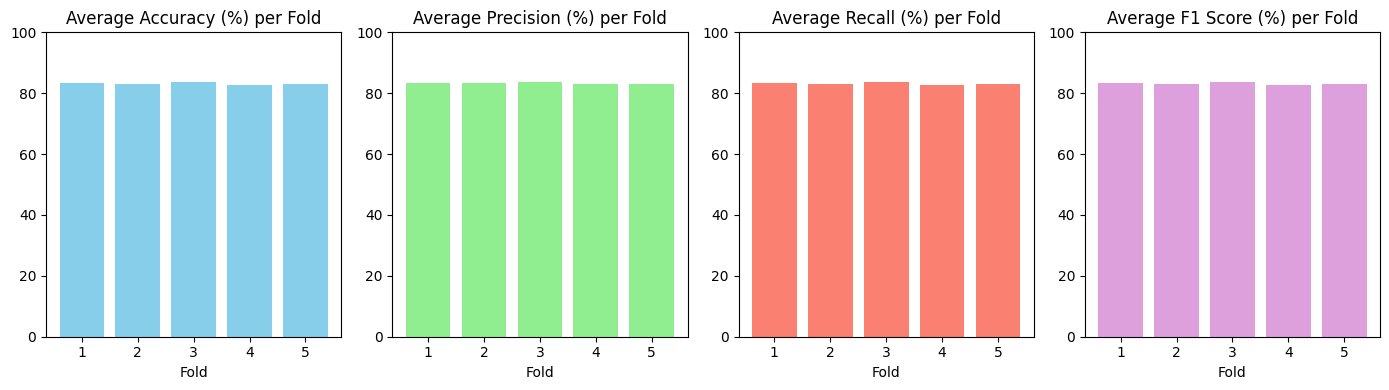


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     83.33       83.33       83.33       83.33       
2     83.11       83.25       83.11       83.09       
3     83.57       83.62       83.57       83.56       
4     82.83       82.96       82.83       82.82       
5     82.94       82.95       82.94       82.94       


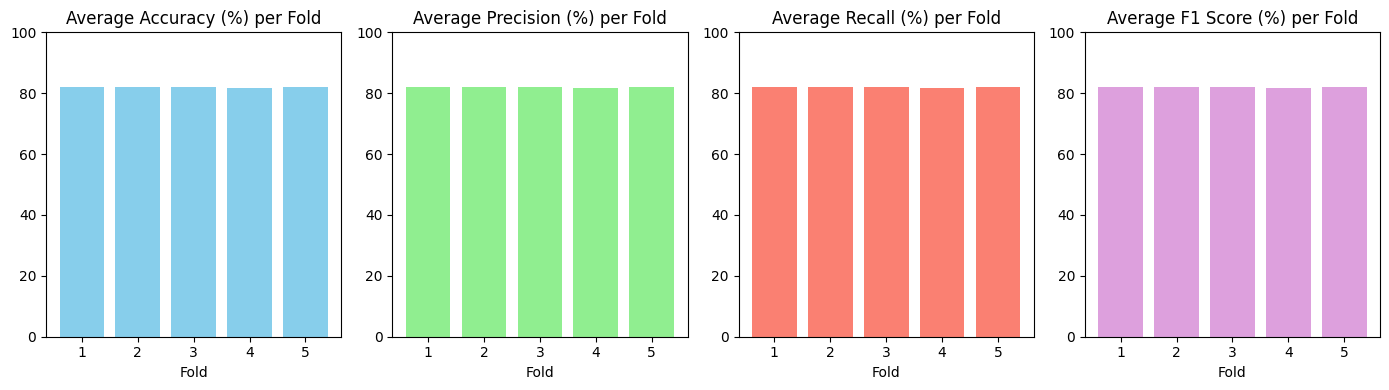


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     81.91       81.98       81.91       81.90       
2     81.94       81.98       81.94       81.94       
3     82.12       82.16       82.12       82.11       
4     81.76       81.79       81.76       81.75       
5     81.89       81.91       81.89       81.88       


In [ ]:
# Plot cross-validation performance metrics (average of epochs) per fold
plot_avg_epoch_metrics_per_fold(best_fold_results_pretrained_model)
plot_avg_epoch_metrics_per_fold(best_fold_results_custom_model)

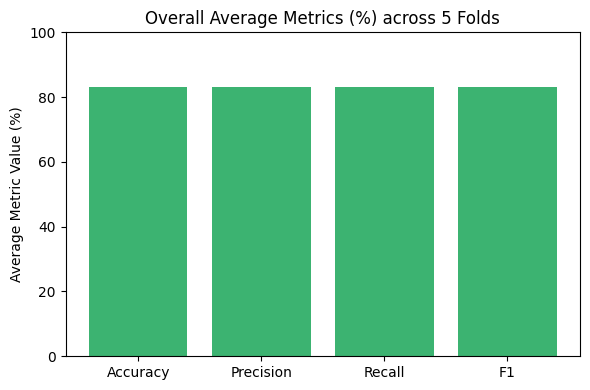


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         83.16
Precision        83.22
Recall           83.16
F1               83.15


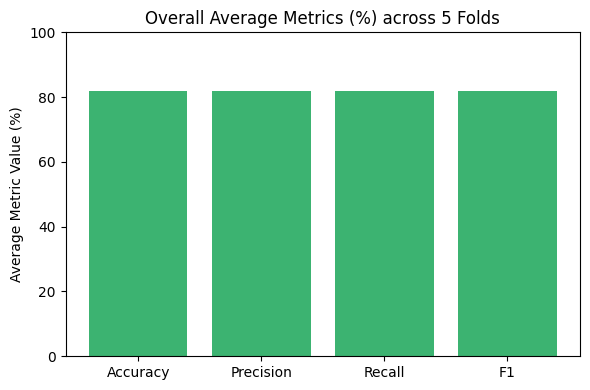


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         81.92
Precision        81.97
Recall           81.92
F1               81.92


In [ ]:
# Plot average performance metrics (average of epochs) for 5-fold
plot_avg_epoch_metrics_across_folds(best_fold_results_pretrained_model)
plot_avg_epoch_metrics_across_folds(best_fold_results_custom_model)

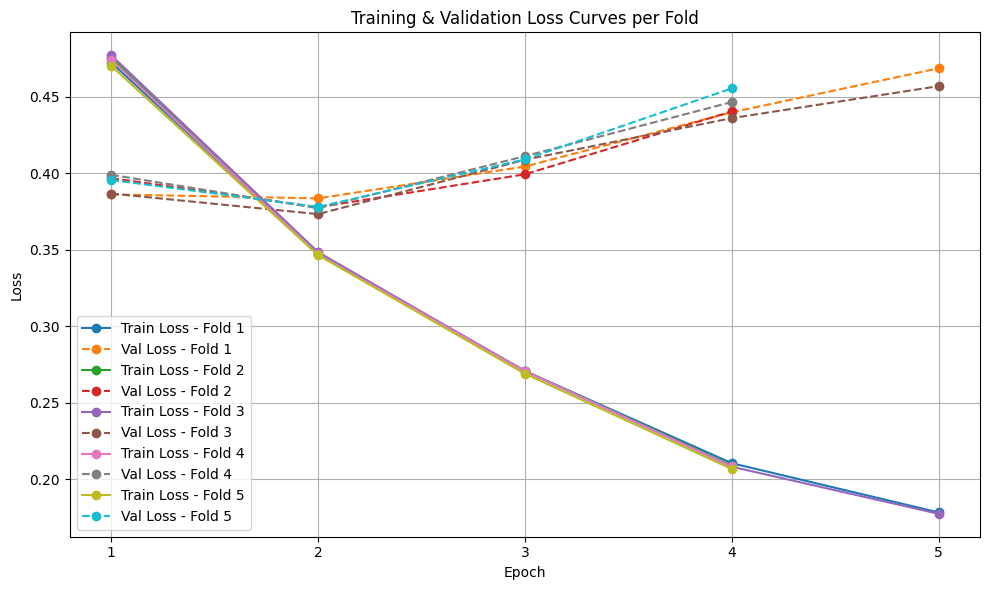


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4725         0.3862         
1     2       0.3476         0.3837         
1     3       0.2707         0.4045         
1     4       0.2104         0.4400         
1     5       0.1782         0.4688         
--------------------------------------------------
2     1       0.4757         0.3969         
2     2       0.3473         0.3779         
2     3       0.2708         0.3994         
2     4       0.2088         0.4406         
--------------------------------------------------
3     1       0.4773         0.3868         
3     2       0.3485         0.3734         
3     3       0.2705         0.4089         
3     4       0.2081         0.4362         
3     5       0.1773         0.4571         
--------------------------------------------------
4     1       0.4744         0.3991  

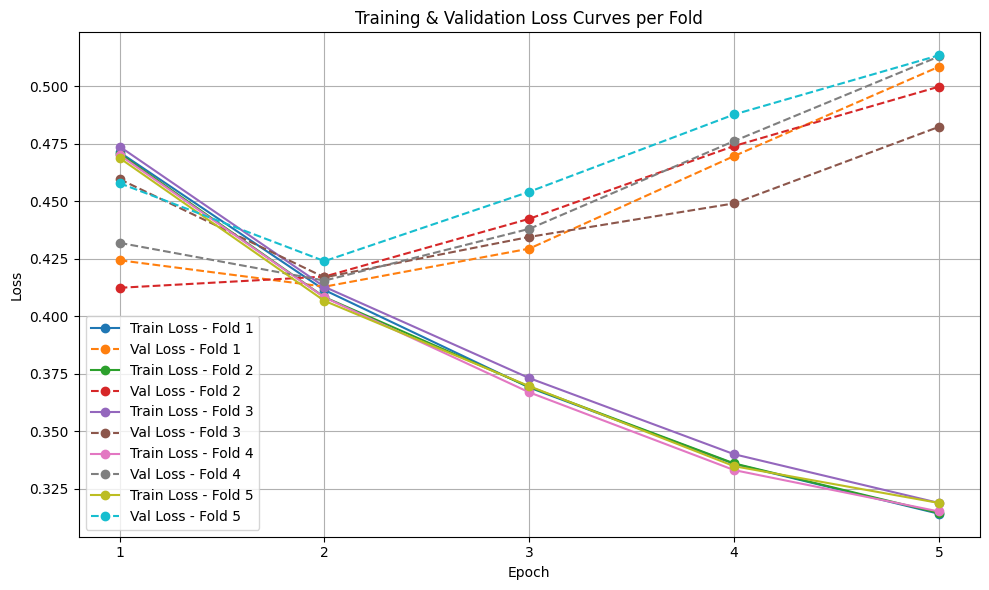


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4712         0.4243         
1     2       0.4113         0.4128         
1     3       0.3689         0.4293         
1     4       0.3357         0.4696         
1     5       0.3140         0.5084         
--------------------------------------------------
2     1       0.4706         0.4123         
2     2       0.4082         0.4172         
2     3       0.3692         0.4423         
2     4       0.3359         0.4740         
2     5       0.3143         0.4998         
--------------------------------------------------
3     1       0.4737         0.4595         
3     2       0.4127         0.4168         
3     3       0.3730         0.4344         
3     4       0.3399         0.4490         
3     5       0.3187         0.4823         
-------------------------------------------

,Fold,Epoch,Train Loss,Validation Loss
0,1,1,0.4712,0.424257
1,1,2,0.4113,0.412766
2,1,3,0.3689,0.429320
3,1,4,0.3357,0.469594
4,1,5,0.3140,0.508430
5,2,1,0.4706,0.412283
6,2,2,0.4082,0.417160
7,2,3,0.3692,0.442301
8,2,4,0.3359,0.473957
9,2,5,0.3143,0.499774


In [ ]:
# Plot training and validation loss curves per fold
plot_loss_per_fold(best_fold_results_pretrained_model)
plot_loss_per_fold(best_fold_results_custom_model)

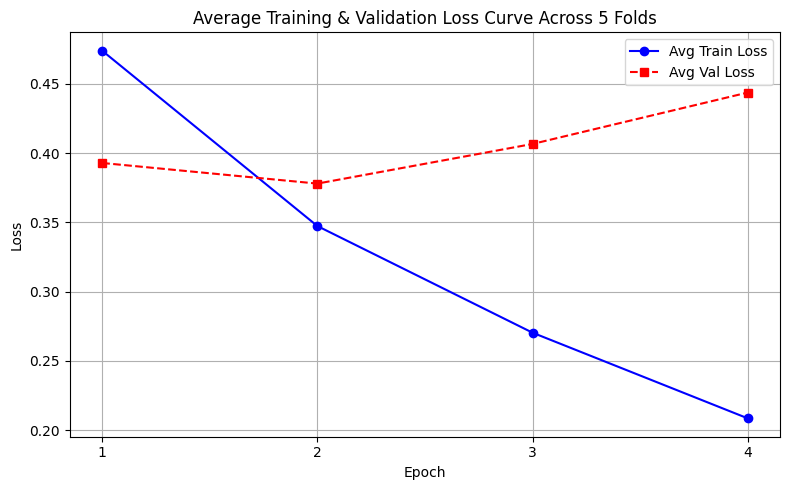


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4740          0.3929          
2       0.3474          0.3780          
3       0.2703          0.4067          
4       0.2084          0.4438          


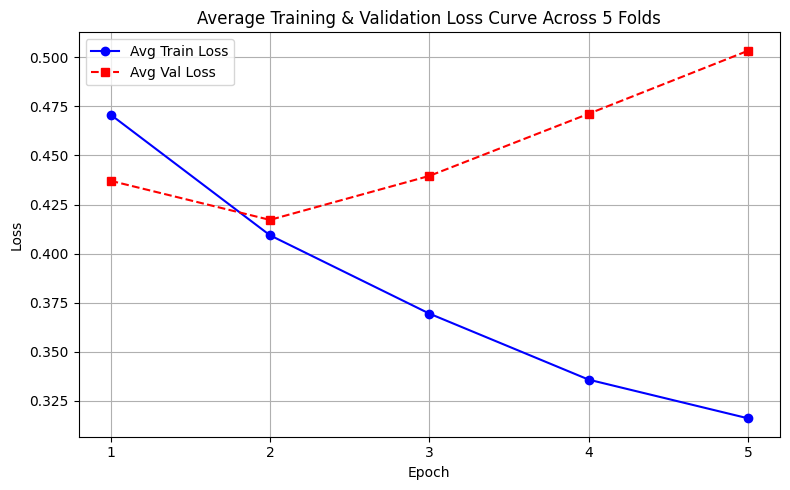


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4708          0.4371          
2       0.4094          0.4172          
3       0.3695          0.4396          
4       0.3358          0.4713          
5       0.3161          0.5034          


,Epoch,Avg Train Loss,Avg Validation Loss
0,1,0.47084,0.437130
1,2,0.40938,0.417203
2,3,0.36948,0.439601
3,4,0.33584,0.471262
4,5,0.31614,0.503360


In [ ]:
# Plot average training and validation loss curves for 5-fold
plot_avg_loss_across_folds(best_fold_results_pretrained_model)
plot_avg_loss_across_folds(best_fold_results_custom_model)

---
# **4.2 Final Model Training**

## Define Best Final Training Arguments

In [ ]:
def create_best_training_args(best_params, model_loader):
    # Create a new TrainingArguments object using best_params
    best_training_args = TrainingArguments(
        output_dir=f"./best_tuned_final_results_{model_loader.__name__}",
        do_train=True,
        report_to="none",                # Disable external logging
        eval_strategy="no",              # No evaluation during training
        save_strategy="no",              # Do not save at each epoch
        per_device_train_batch_size=best_params["batch_size"],
        per_device_eval_batch_size=best_params["batch_size"],
        num_train_epochs=5,
        learning_rate=best_params["learning_rate"],
        weight_decay=best_params["weight_decay"],
        fp16=True,                       # Enable mixed precision training
        gradient_accumulation_steps=best_params["grad_acc"],
        logging_dir=f"./best_tuned_final_logs_{model_loader.__name__}",
        logging_strategy="epoch",
        seed=42,
        # Additional parameters with defaults if not set in best_params
        warmup_steps=best_params.get("warmup_steps", 0),
        max_grad_norm=best_params.get("max_grad_norm", 1.0),
        adam_epsilon=best_params.get("adam_epsilon", 1e-8),
        lr_scheduler_type=best_params.get("scheduler", "linear"),
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True
    )
    return best_training_args

In [ ]:
# Train the final model using pretrained DistilBert
model_loader = load_pretrained_model
training_args = create_best_training_args(best_params1, model_loader)
tuned_final_pretrained_trainer, tuned_final_pretrained_model = train_final_model(full_train_dataset, training_args, model_loader)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-31-e6ccdbd24bf5>:10: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Step,Training Loss
625,0.459400
1250,0.338200
1875,0.264400
2500,0.206100
3125,0.176200


In [ ]:
# Train on the full training set (already tokenized)
best_model_loader = lambda: load_custom_model(
    hidden_units=[best_params2[k] for k in hidden_unit_keys],
    dropout_rate=best_params2["dropout_rate"],
    activation=activation_map[best_params2["activation"]]
)
training_args = create_best_training_args(best_params2, best_model_loader)
tuned_final_custom_trainer, tuned_final_custom_model = train_final_model(full_train_dataset, training_args, best_model_loader)

<ipython-input-31-e6ccdbd24bf5>:10: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Step,Training Loss
10000,0.465000
20000,0.404700
30000,0.365700
40000,0.332400
50000,0.314700


---
# **4.3 Final Model Evaluation**

In [ ]:
# Evaluate the final model using pretrained DistilBert
evaluate_final_model(tuned_final_pretrained_trainer, test_dataset)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8293 (82.93%)
Precision      0.8295 (82.95%)
Recall         0.8293 (82.93%)
F1 Score       0.8293 (82.93%)
Loss           0.4783
--------------------------------------------------


{'eval_loss': 0.4782569408416748,
 'eval_accuracy': 0.8293,
 'eval_precision': 0.8294623722355325,
 'eval_recall': 0.8293,
 'eval_f1': 0.8292789654613345,
 'eval_runtime': 8.2427,
 'eval_samples_per_second': 2426.401,
 'eval_steps_per_second': 75.825,
 'epoch': 5.0}

In [ ]:
# Evaluate the final model using custom DistilBert
evaluate_final_model(tuned_final_custom_trainer, test_dataset)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8215 (82.14%)
Precision      0.8216 (82.16%)
Recall         0.8215 (82.14%)
F1 Score       0.8214 (82.14%)
Loss           0.5042
--------------------------------------------------


{'eval_loss': 0.5042343735694885,
 'eval_accuracy': 0.82145,
 'eval_precision': 0.8215959048460696,
 'eval_recall': 0.82145,
 'eval_f1': 0.8214297461153789,
 'eval_runtime': 21.8539,
 'eval_samples_per_second': 915.168,
 'eval_steps_per_second': 114.396,
 'epoch': 5.0}

---
# **4.4 Final Model Prediction**

## Predict, Compute and Print Evaluation Metrics


Final Model Predictions Summary
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8293 (82.93%)
Precision      0.8295 (82.95%)
Recall         0.8293 (82.93%)
F1 Score       0.8293 (82.93%)
--------------------------------------------------

Classification Report (Per Class):
              precision    recall  f1-score   support

    Negative     0.8221    0.8404    0.8312     10000
    Positive     0.8368    0.8182    0.8274     10000

    accuracy                         0.8293     20000
   macro avg     0.8295    0.8293    0.8293     20000
weighted avg     0.8295    0.8293    0.8293     20000


Confusion Matrix:
[[8404 1596]
 [1818 8182]]

Confusion matrix saved to ./2_Fine_Tuned_Pretrained_Model_Cleaned_Tweets/confusion_matrix.png



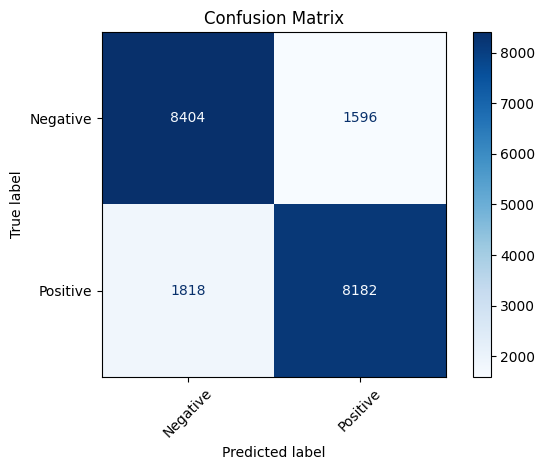

In [ ]:
model_name = "2_Fine_Tuned_Pretrained_Model_Cleaned_Tweets"

# Get predictions, metrics from confusion matrix and save visualization
prediction_metrics, cm, preds, labels = predict_final_model_with_metrics(
    tuned_final_pretrained_trainer,
    test_dataset,
    output_dir=f"./{model_name}",
    class_labels=["Negative", "Positive"]
)


Final Model Predictions Summary
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8215 (82.14%)
Precision      0.8216 (82.16%)
Recall         0.8215 (82.14%)
F1 Score       0.8214 (82.14%)
--------------------------------------------------

Classification Report (Per Class):
              precision    recall  f1-score   support

    Negative     0.8147    0.8321    0.8233     10000
    Positive     0.8284    0.8108    0.8195     10000

    accuracy                         0.8215     20000
   macro avg     0.8216    0.8215    0.8214     20000
weighted avg     0.8216    0.8215    0.8214     20000


Confusion Matrix:
[[8321 1679]
 [1892 8108]]

Confusion matrix saved to ./2_Fine_Tuned_Custom_Model_Cleaned_Tweets/confusion_matrix.png



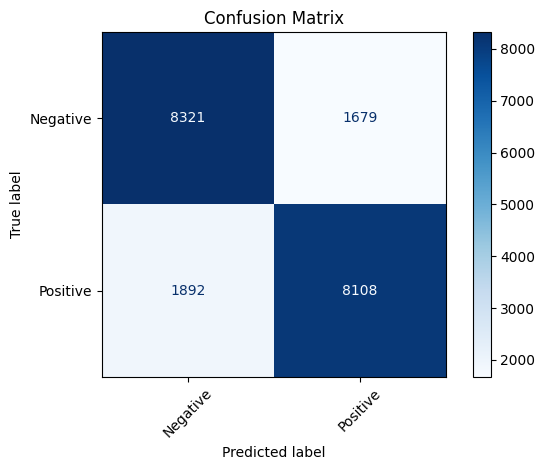

In [ ]:
model_name = "2_Fine_Tuned_Custom_Model_Cleaned_Tweets"

# Get predictions, metrics from confusion matrix and save visualization
prediction_metrics, cm, preds, labels = predict_final_model_with_metrics(
    tuned_final_custom_trainer,
    test_dataset,
    output_dir=f"./{model_name}",
    class_labels=["Negative", "Positive"]
)

---
# **4.5 Save Final Model**

In [ ]:
model_name = "2_Fine_Tuned_Pretrained_Model_Cleaned_Tweets"
final_model_eval_metrics = evaluate_final_model(tuned_final_pretrained_trainer, test_dataset)
metrics3 = {
    "trainer_evaluation": final_model_eval_metrics,
    "confusion_matrix_metrics": prediction_metrics
}
save_model_to_drive(tuned_final_pretrained_model, tokenizer, model_name, metrics=metrics3)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8293 (82.93%)
Precision      0.8295 (82.95%)
Recall         0.8293 (82.93%)
F1 Score       0.8293 (82.93%)
Loss           0.4783
--------------------------------------------------
Mounted at /content/drive
Model and metrics saved to Google Drive at: /content/drive/My Drive/Colab Notebooks/IT1244 Project/Saved Model/2_Fine_Tuned_Pretrained_Model_Cleaned_Tweets


In [ ]:
model_name = "2_Fine_Tuned_Custom_Model_Cleaned_Tweets"
final_model_eval_metrics = evaluate_final_model(tuned_final_custom_trainer, test_dataset)
metrics4 = {
    "trainer_evaluation": final_model_eval_metrics,
    "confusion_matrix_metrics": prediction_metrics
}
save_model_to_drive(tuned_final_custom_model, tokenizer, model_name, metrics=metrics4)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8215 (82.14%)
Precision      0.8216 (82.16%)
Recall         0.8215 (82.14%)
F1 Score       0.8214 (82.14%)
Loss           0.5042
--------------------------------------------------
Mounted at /content/drive
Model and metrics saved to Google Drive at: /content/drive/My Drive/Colab Notebooks/IT1244 Project/Saved Model/2_Fine_Tuned_Custom_Model_Cleaned_Tweets
